# Implementation

In [127]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

## Quantization

### Section A

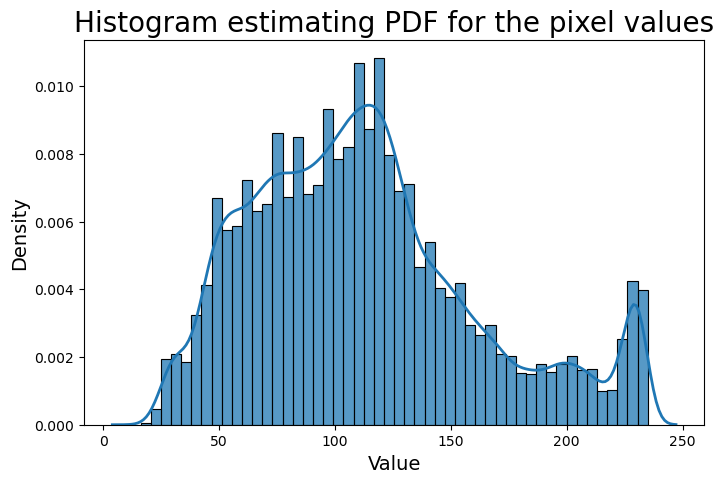

In [128]:
# path to the image file
img_path = 'images/houses.png'

# plot the pixel-value histogram
img = np.asarray(Image.open(img_path))
values = img.flatten()
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(values, bins=50, stat="density", ax=ax, label='Empirical Density')
sns.kdeplot(values, ax=ax, linewidth=2, label='Estimated PDF')
plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Histogram estimating PDF for the pixel values', fontsize=20)
plt.show()

### Section B

We have $b$ bits, therefore, we have $k:=2^b$ representation levels $\{r_i\}_{i=1}^{2^b}$ and $k-1=2^b-1$ decision boundaries $\{d_i\}_{i=1}^{2^b-1}$.

We have seen in the tutorial that uniform quantization has the following form:

1. $\textbf{Uniform decision levels} \quad - \quad$
        $
           d_i = \varphi_L + i\,\Delta,
           \qquad 0 \le i \le k
        $

2. $\textbf{Uniform representation levels} \quad - \quad$
        $
           r_i = \varphi_L + \left(i - \tfrac{1}{2}\right)\Delta,
           \qquad 1 \le i \le k
        $

3. $\textbf{Uniform quantisation function} \quad - \quad$
        $
           Q(x) =
           \varphi_L + \Bigl( \Bigl\lfloor \tfrac{x - \varphi_L}{\Delta} \Bigr\rfloor + \tfrac{1}{2} \Bigr)\,\Delta
        $


where $\Delta = \frac{\phi_L - \phi_H}{k}$ - is the length of each interval

In [129]:
PHI_L = 0
PHI_H = 256

# decision levels
def uniformly_quantize(img: np.array, b: int) -> np.array:
    d = list()
    r = list()
    k = 2 ** b
    
    delta = (PHI_H - PHI_L) / k

    # decision levels
    d = np.linspace(PHI_L, PHI_H, k + 1)
    r = np.zeros(k)

    # representation levels
    for i in range(len(d)-1):
        r[i] = np.rint(np.mean(np.arange(d[i], d[i+1], 1)))

    # quantized image
    quantized_img = np.round(PHI_L + (((np.floor((img - PHI_L) / delta)) + 0.5) * delta))

    return r, d, quantized_img

The Expected Squared Error (ESE), given the density of the pixel-values (continous) is:

$$
\sum_{i=1}^{k} \int_{d_{i-1}}^{d_i} (x - r_i)^2 p(x)\,dx
$$

This easily translates to the discrete approximation of the ESE, given a PDF histogram:

$$
\sum_{i=1}^{k} \sum_{x = d_{i-1}}^{d_i - 1} (x - r_i)^2 \cdot \hat{p}(x)
$$

where $\quad
\hat{p}(x) = \frac{h(x)}{\sum_{j} h(j)}$, and $h(x)$ is the count of how many times the intensity of a pixel $x$.

This error is exactly equal to the MSE between the quantized image and the original image, since:

In [130]:
def compute_mse(hist: np.array, representations: np.array, decisions: np.array) -> float:
    """Computes MSE between the quantization defined by the given representation and decision levels, and the image with this PDF"""
    n_pixels = hist.sum()
    pdf = hist / n_pixels
    
    curr_l, curr_h = decisions[0], decisions[1]
    counter = 0
    mse = 0
    
    # quantize the image according to the given levels
    for val, count in enumerate(hist):
        if not (curr_l <= val < curr_h):
            counter += 1
            curr_l, curr_h = decisions[counter], decisions[counter+1]
        Q = representations[counter]
        mse += (pdf[val] * ((Q - val) ** 2))
    return mse   

Let's show the quantized images

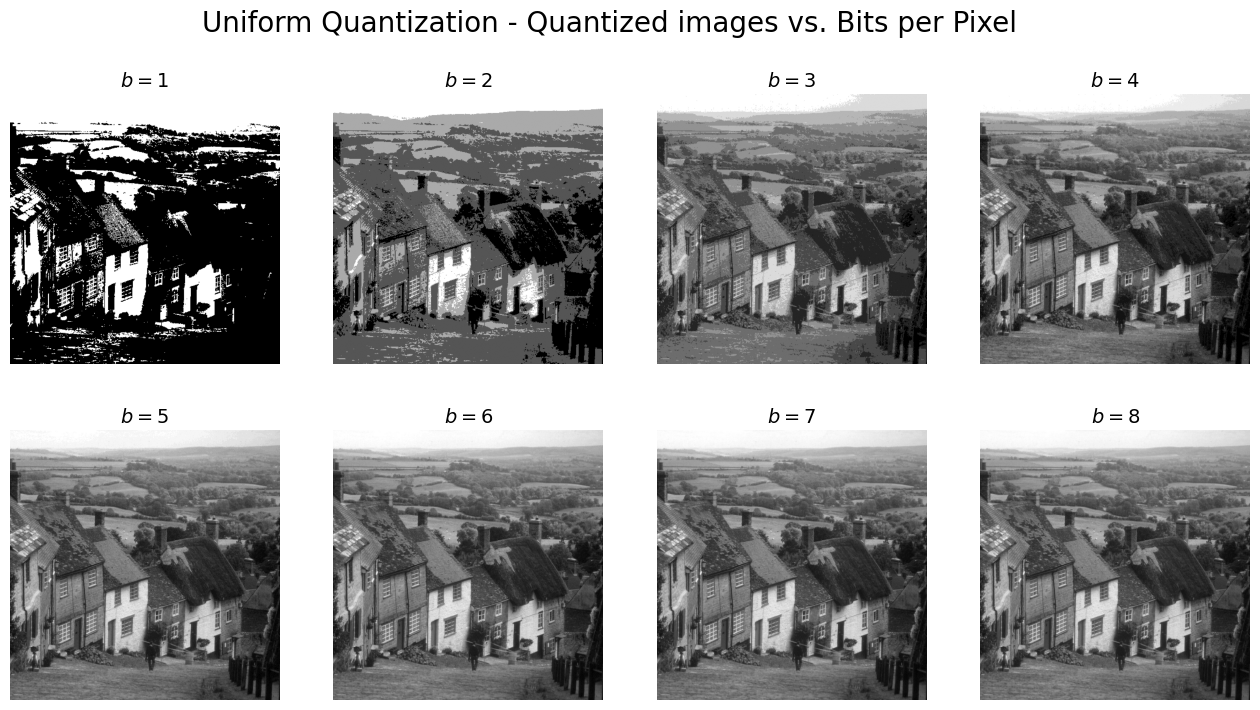

In [131]:
mse_errors = list()
histogram = np.array(Image.open('images/houses.png').histogram())
fig, axes = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle('Uniform Quantization - Quantized images vs. Bits per Pixel', fontsize=20)
for bits, ax in enumerate(axes.ravel()):
    representation, decision, quantized_img = uniformly_quantize(img=values, b=bits+1)
    ax.set_axis_off()
    ax.imshow(quantized_img.reshape(512, 512), cmap='gray')
    ax.set_title(f"$b={bits+1}$", fontsize=14)
    mse = compute_mse(histogram, representation, decision)
    mse_errors.append(mse)

plt.savefig('images/q_image.png')

Now, let's show how the MSE error evolves with the bit-budget we have

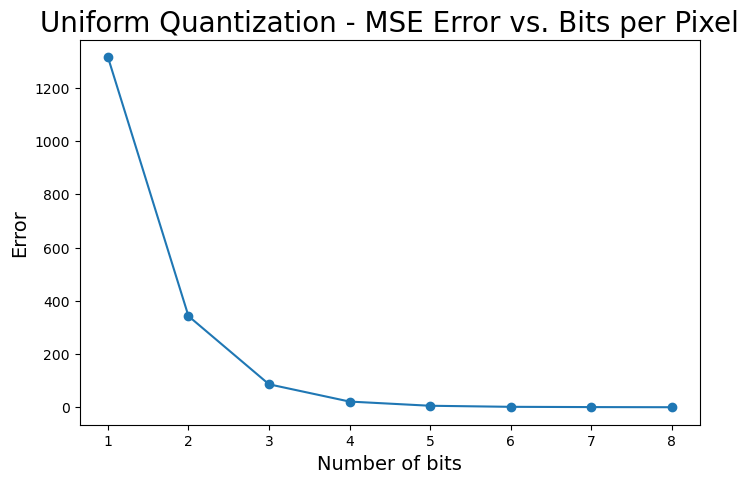

In [132]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, 9), mse_errors, marker='o')
plt.title('Uniform Quantization - MSE Error vs. Bits per Pixel', fontsize=20)
plt.xlabel('Number of bits', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.show()

Next, we show the decision and representation levels

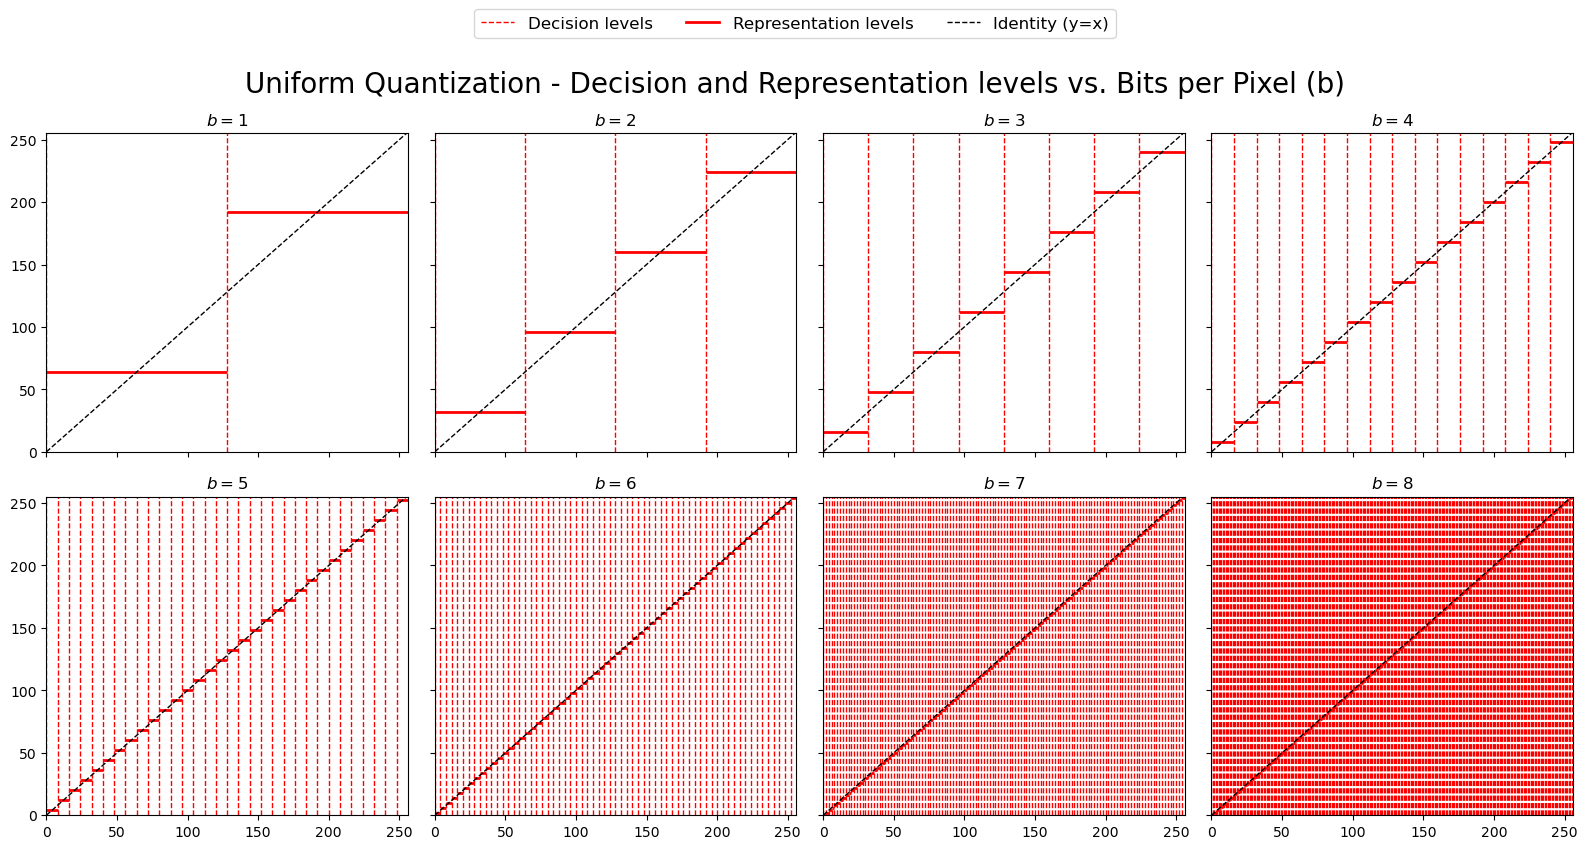

In [134]:
def show_decisions_representations(title, histogram):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)
    fig.suptitle(f'{title} - Decision and Representation levels vs. Bits per Pixel (b)', fontsize=20)
    
    for b, ax in enumerate(axes.ravel()):
        if title == 'Uniform Quantization':
            representation, decision, _ = uniformly_quantize(img=values, b=b+1)
        else:
            _, d, _ = uniformly_quantize(img=values, b=b+1)
            representation, decision = lloyd_max_quantize(histogram, d, epsilon=1e-3)
        
        # vertical decision levels
        for i, d in enumerate(decision[:-1]):
            ax.vlines(x=d,
                      ymin=0,
                      ymax=256,
                      colors='red',
                      linestyles='--',
                      linewidth=1)
    
        # 2) horizontal representation levels
        for i in range(len(representation)):
            ax.hlines(y=representation[i],
                      xmin=decision[i],
                      xmax=decision[i+1],
                      colors='red',
                      linestyles='-',
                      linewidth=2)
    
        # identity line for reference
        ax.plot(decision, decision, 'k--', linewidth=1)
    
        ax.set_xticks(np.arange(0, 300, 50))  
        ax.set_yticks(np.arange(0, 300, 50))
        ax.set_title(f'$b={b+1}$')
    
        # set axis limits
        ax.set_xlim(decision[0], decision[-1])
        ax.set_ylim(representation[0], representation[-1])
    
    # build our legend handles
    legend_elements = [
        Line2D([0], [0], color='red',   linestyle='--', lw=1, label='Decision levels'),
        Line2D([0], [0], color='red',   linestyle='-',  lw=2, label='Representation levels'),
        Line2D([0], [0], color='k',     linestyle='--', lw=1, label='Identity (y=x)'),
    ]
    
    # put legend 
    fig.legend(handles=legend_elements,
               loc='lower center',
               ncol=3,
               bbox_to_anchor=(0.5, 1.01),
               fontsize=12)
    
    plt.tight_layout()
    plt.show()

show_decisions_representations('Uniform Quantization', None)

### Section C

In [152]:
def lloyd_max_quantize(histogram: np.array, d: np.array, epsilon: float, verbose=False) -> (np.array, np.array):
    
    pdf = histogram / histogram.sum()

    # initial representation levels
    r = np.zeros(len(d) - 1)
    for i in range(len(d) - 1):
        r[i] = np.rint(np.mean(np.arange(d[i], d[i+1], 1)))

    old_error = compute_mse(histogram, r, d)

    # if already optimal, return
    if old_error == 0:
        return r, d

    error_diff = np.inf
    n_iter = 0
    N = len(d) - 1
    new_dec = d.copy()
    all_intensities = np.arange(0, 256, 1)
    best_results = r.copy(), d.copy()
    
    while error_diff > epsilon:
        n_iter += 1
        
        # update r_i
        new_repr = np.zeros_like(r)
        for i in range(N):
            d_i, d_ip1 = np.rint(new_dec[i]).astype(np.int64), np.rint(new_dec[i+1]).astype(np.int64)
            
            p  = pdf[d_i:d_ip1]  # probabilities in bin
            vals = all_intensities[d_i:d_ip1]  # values in the bin
            
            if p.sum() > 0:
                # weighted average of intensities
                new_repr[i] = np.dot(vals, p) / p.sum()
            else:
                # empty interval handling
                new_repr[i] = 0.5 * (d_i + d_ip1)
        
        # update d_i
        for i in range(1, N):
            new_dec[i] = 0.5 * (new_repr[i-1] + new_repr[i])
        
        # compute MSE
        new_error = compute_mse(histogram, new_repr, new_dec)
        if verbose:
            print(f"Iteration: {n_iter}, Error: {new_error}")
        error_diff = old_error - new_error
        if error_diff > 0:
            best_results = new_repr.copy(), new_dec.copy()
        old_error = new_error
    if verbose:
        print(f"\n\nAlgorithm converged!")
    
    return best_results

### Section D

In [153]:
def quantizer(img: np.array, r: np.array, d: np.array) -> np.array:
    """Quantizes the image with the given representation values according to the given decision levels"""
    vals = img.reshape(-1)
    quantized_img = np.zeros(vals.shape)
    for j, val in enumerate(vals):
        for i in range(len(d)):
            if d[i] <= val < d[i+1]:
                quantized_img[j] = r[i]
                break
    return quantized_img

Applying Lloyd-Max quantization with 1 bits per pixel


Iteration: 1, Error: 857.3614143377214
Iteration: 2, Error: 857.3614143377214


Algorithm converged!
Applying Lloyd-Max quantization with 2 bits per pixel


Iteration: 1, Error: 234.74417999302153
Iteration: 2, Error: 210.1951600101329
Iteration: 3, Error: 205.02908680459274
Iteration: 4, Error: 204.0421018000375
Iteration: 5, Error: 204.00106623760252
Iteration: 6, Error: 204.03539310625195


Algorithm converged!
Applying Lloyd-Max quantization with 3 bits per pixel


Iteration: 1, Error: 71.03191812586867
Iteration: 2, Error: 65.71252461862211
Iteration: 3, Error: 61.87615392756631
Iteration: 4, Error: 59.331269968959724
Iteration: 5, Error: 57.518469960446886
Iteration: 6, Error: 55.95998634037824
Iteration: 7, Error: 54.99437219993616
Iteration: 8, Error: 54.046245038488195
Iteration: 9, Error: 53.52170464355263
Iteration: 10, Error: 53.32618702053591
Iteration: 11, Error: 53.23812351869379
Iteration: 12, Error: 53.17764488218

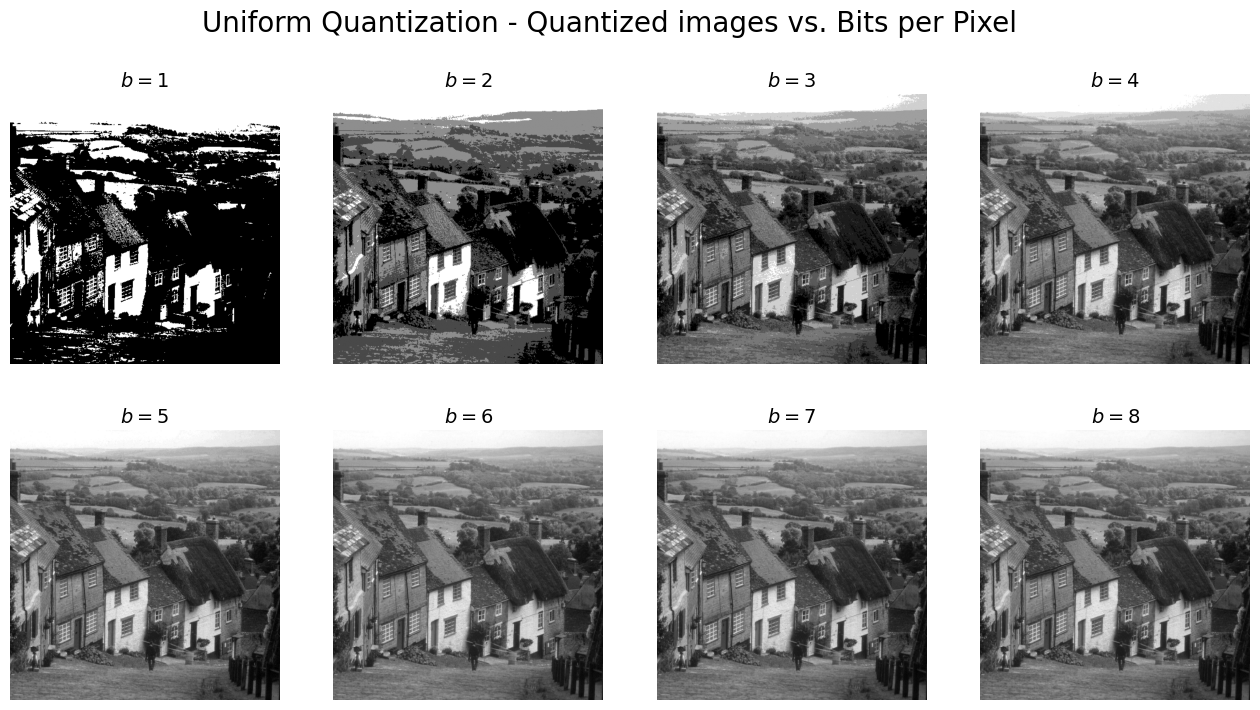

In [154]:
mse_errors = list()
histogram = np.array(Image.open('images/houses.png').histogram())
fig, axes = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle('Uniform Quantization - Quantized images vs. Bits per Pixel', fontsize=20)
for bits, ax in enumerate(axes.ravel()):
    _, d, _ = uniformly_quantize(img, bits+1)
    print(f"Applying Lloyd-Max quantization with {bits+1} bits per pixel\n\n")
    representation, decision = lloyd_max_quantize(histogram, d, epsilon=1e-3, verbose=True)
    quantized_img = quantizer(img, representation, decision)
    ax.set_axis_off()
    ax.imshow(quantized_img.reshape(512, 512), cmap='gray')
    ax.set_title(f"$b={bits+1}$", fontsize=14)
    mse = compute_mse(histogram, representation, decision)
    mse_errors.append(mse)

plt.savefig('images/q_image.png')

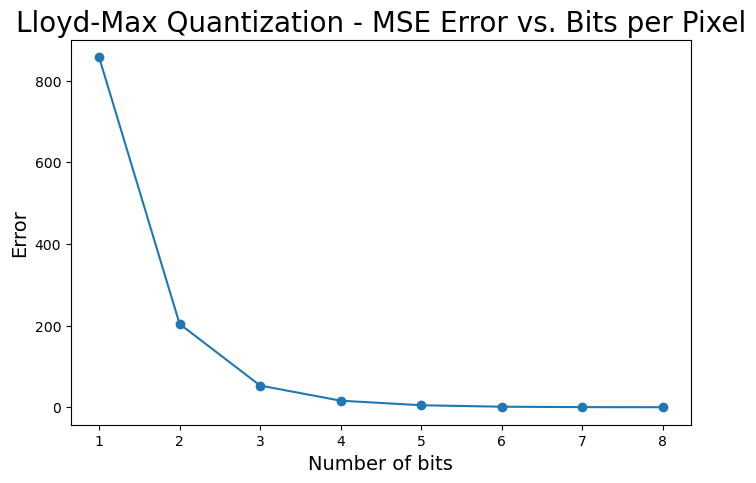

In [155]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, 9), mse_errors, marker='o')
plt.title('Lloyd-Max Quantization - MSE Error vs. Bits per Pixel', fontsize=20)
plt.xlabel('Number of bits', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.show()

Indeed, we see that Lloyd-Max quantization yields lower MSE than the unform quantization for all bit-budgets

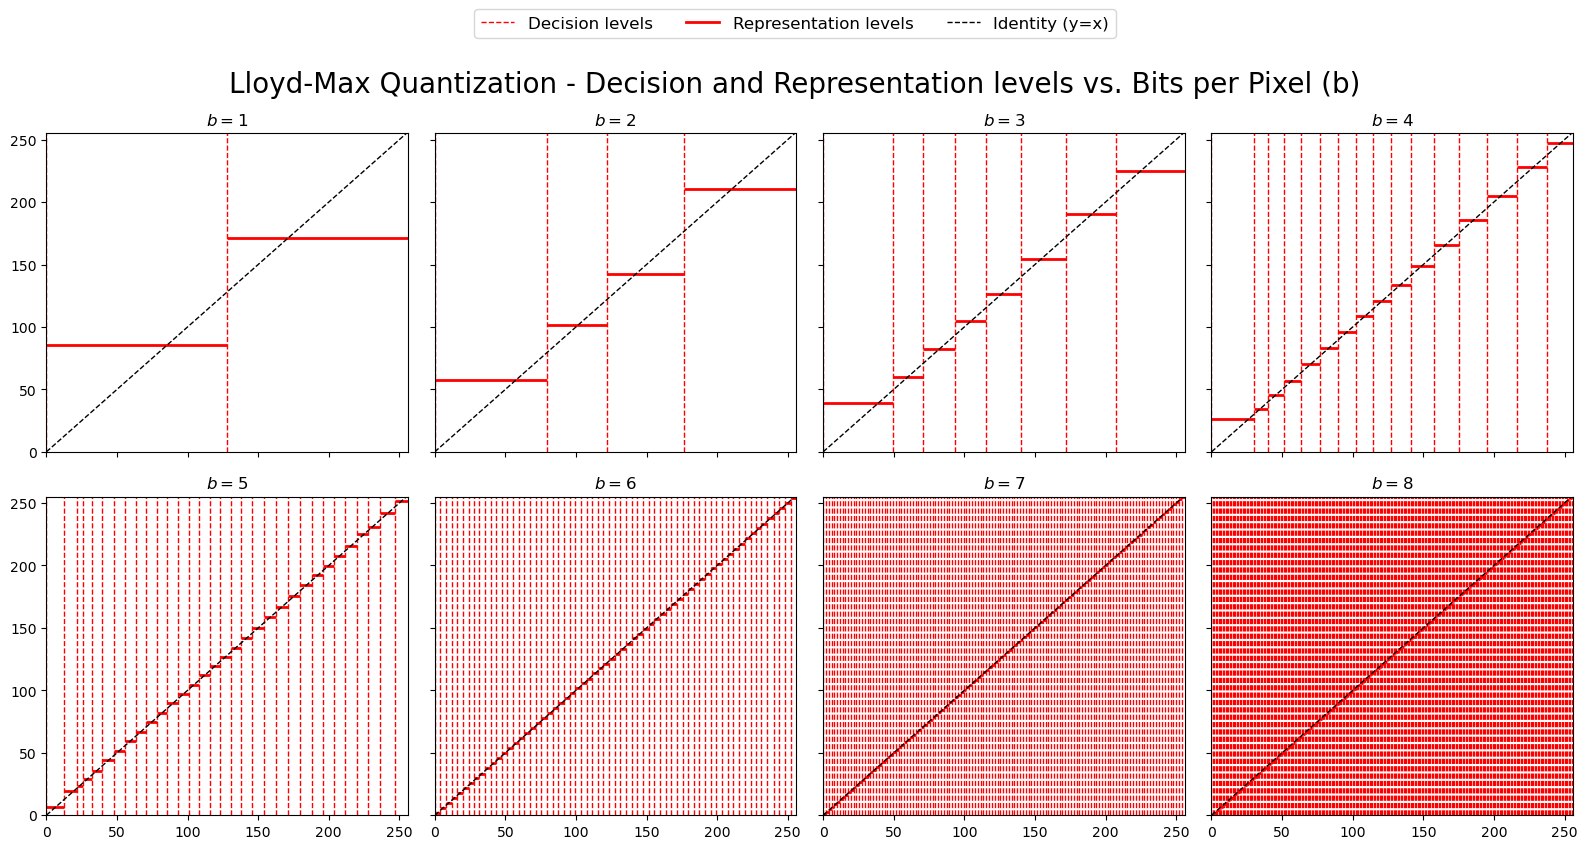

In [156]:
show_decisions_representations('Lloyd-Max Quantization', histogram)

## Subsampling and Reconstruction

## Hadamard, Hadamard-Walsh, and Haar matrices

### Section A

In [180]:
# recursive definition of the Hadamard matrix
def hadamard(n: int) -> np.array:

    # base case
    H2 = (1 / np.sqrt(2)) * np.array([
                    [1,  1],
                    [1, -1]
        ])
    if n == 1:
        return H2
    
    return np.kron(H2, create_hadamard_matrix(n-1))

### Section B

In [208]:
def standard_basis_func(i: int, x: np.ndarray, n: int):
    b = np.linspace(0.0, 1.0, 2**n + 1)
    return ((b[i] <= x) & (x < b[i+1])).astype(float)

# build h_i(t) 
def h_family(n: int, x: np.ndarray):
    k  = 2**n
    H  = hadamard(n)  
    B  = np.vstack([standard_basis_func(j, x, n) for j in range(k)])  # all basis functions
    return np.sqrt(k) * (H.T @ B)     # row i = h_i(t)

x = np.linspace(0, 1, 801, endpoint=False)   

def show_family(transform):
    for n in range(2, 7):
        vals = transform(n, x)
        k = vals.shape[0]
        
        fig, axes = plt.subplots(int(k/4), 4, figsize=(22, 10), sharex=True)
        for i, ax in enumerate(axes.ravel()):
            ax.step(x, vals[i], where='post')
            ax.set_ylim(-1.1, 1.1)
            ax.set_yticks([-1, 0, 1]) 
            ax.grid(True, axis='y', ls=':')   
        # axes[-1].set_xlabel('t')
        fig.suptitle(f'n = {n}', fontsize=20)
        plt.tight_layout()
        plt.show()

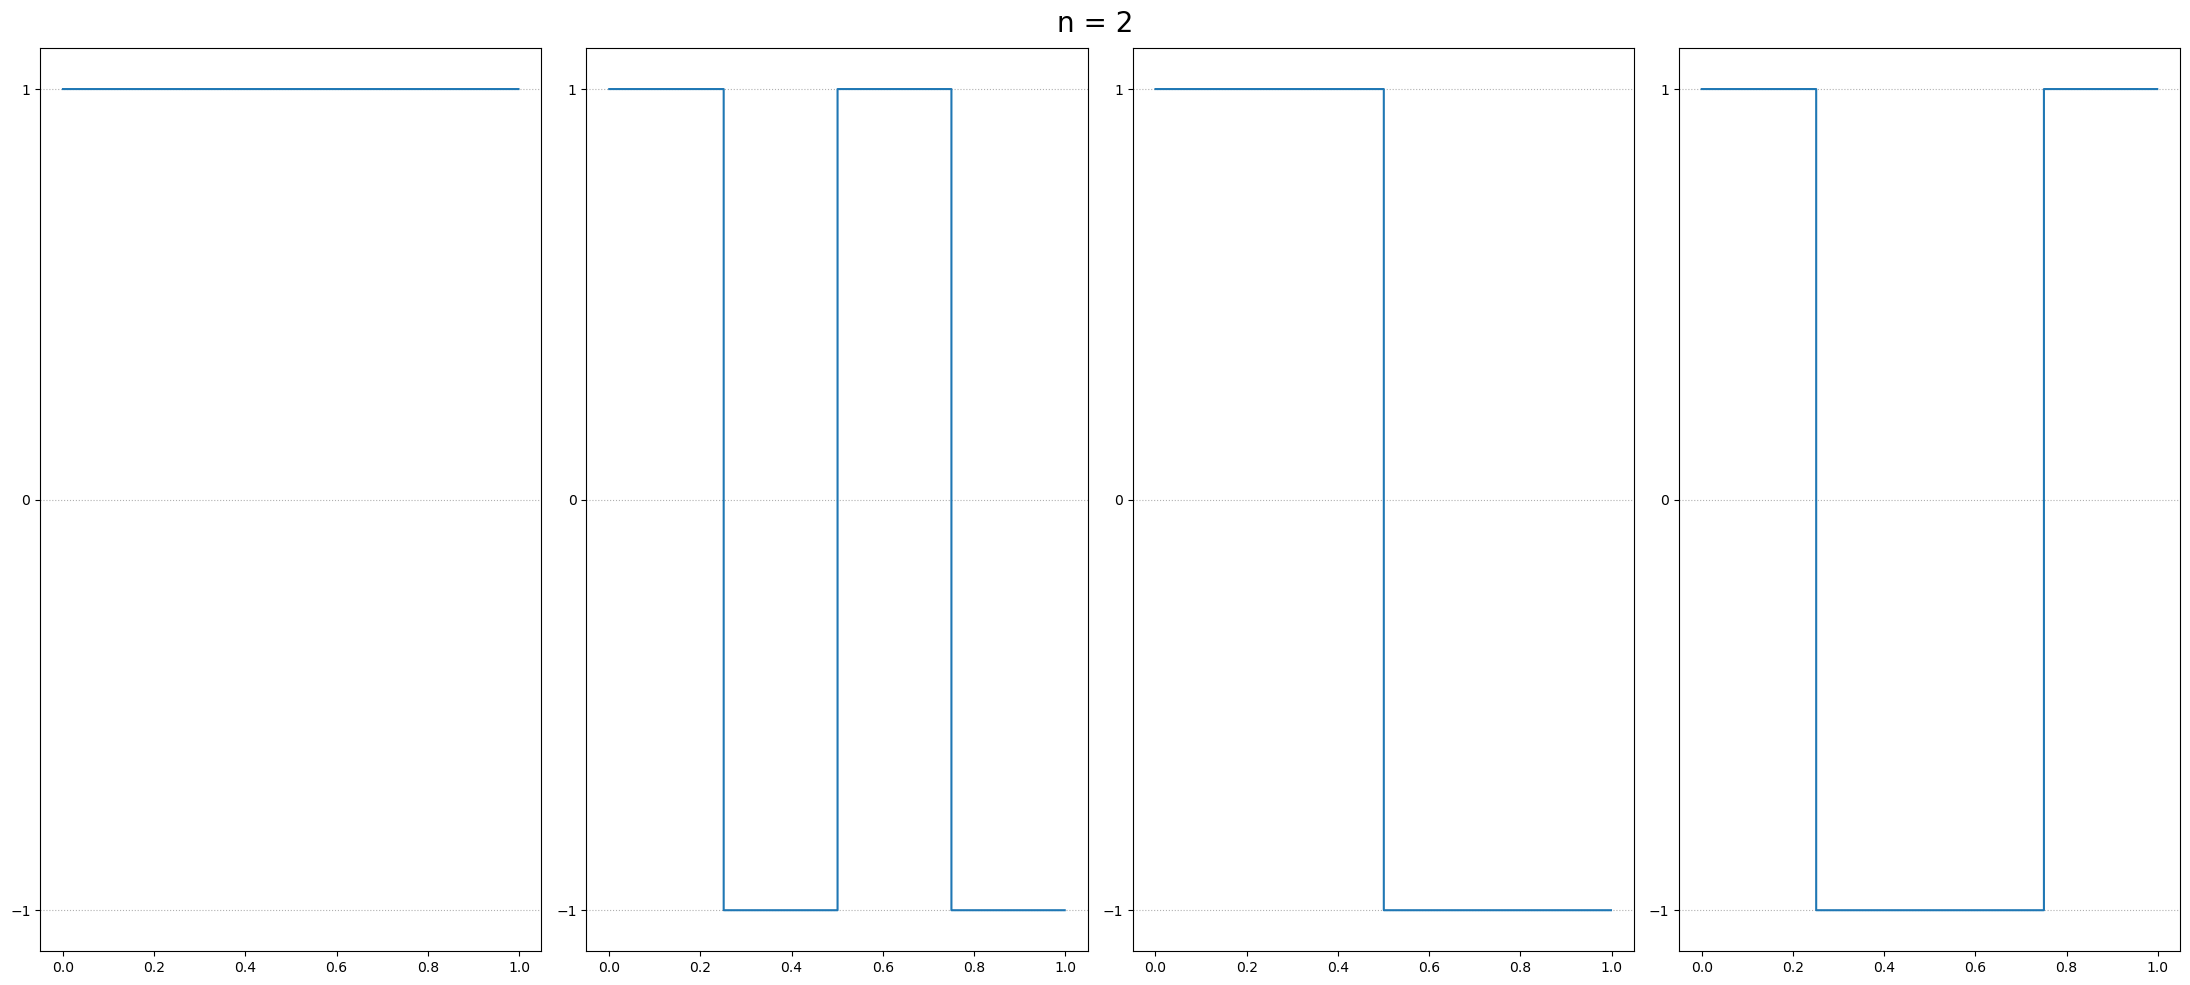

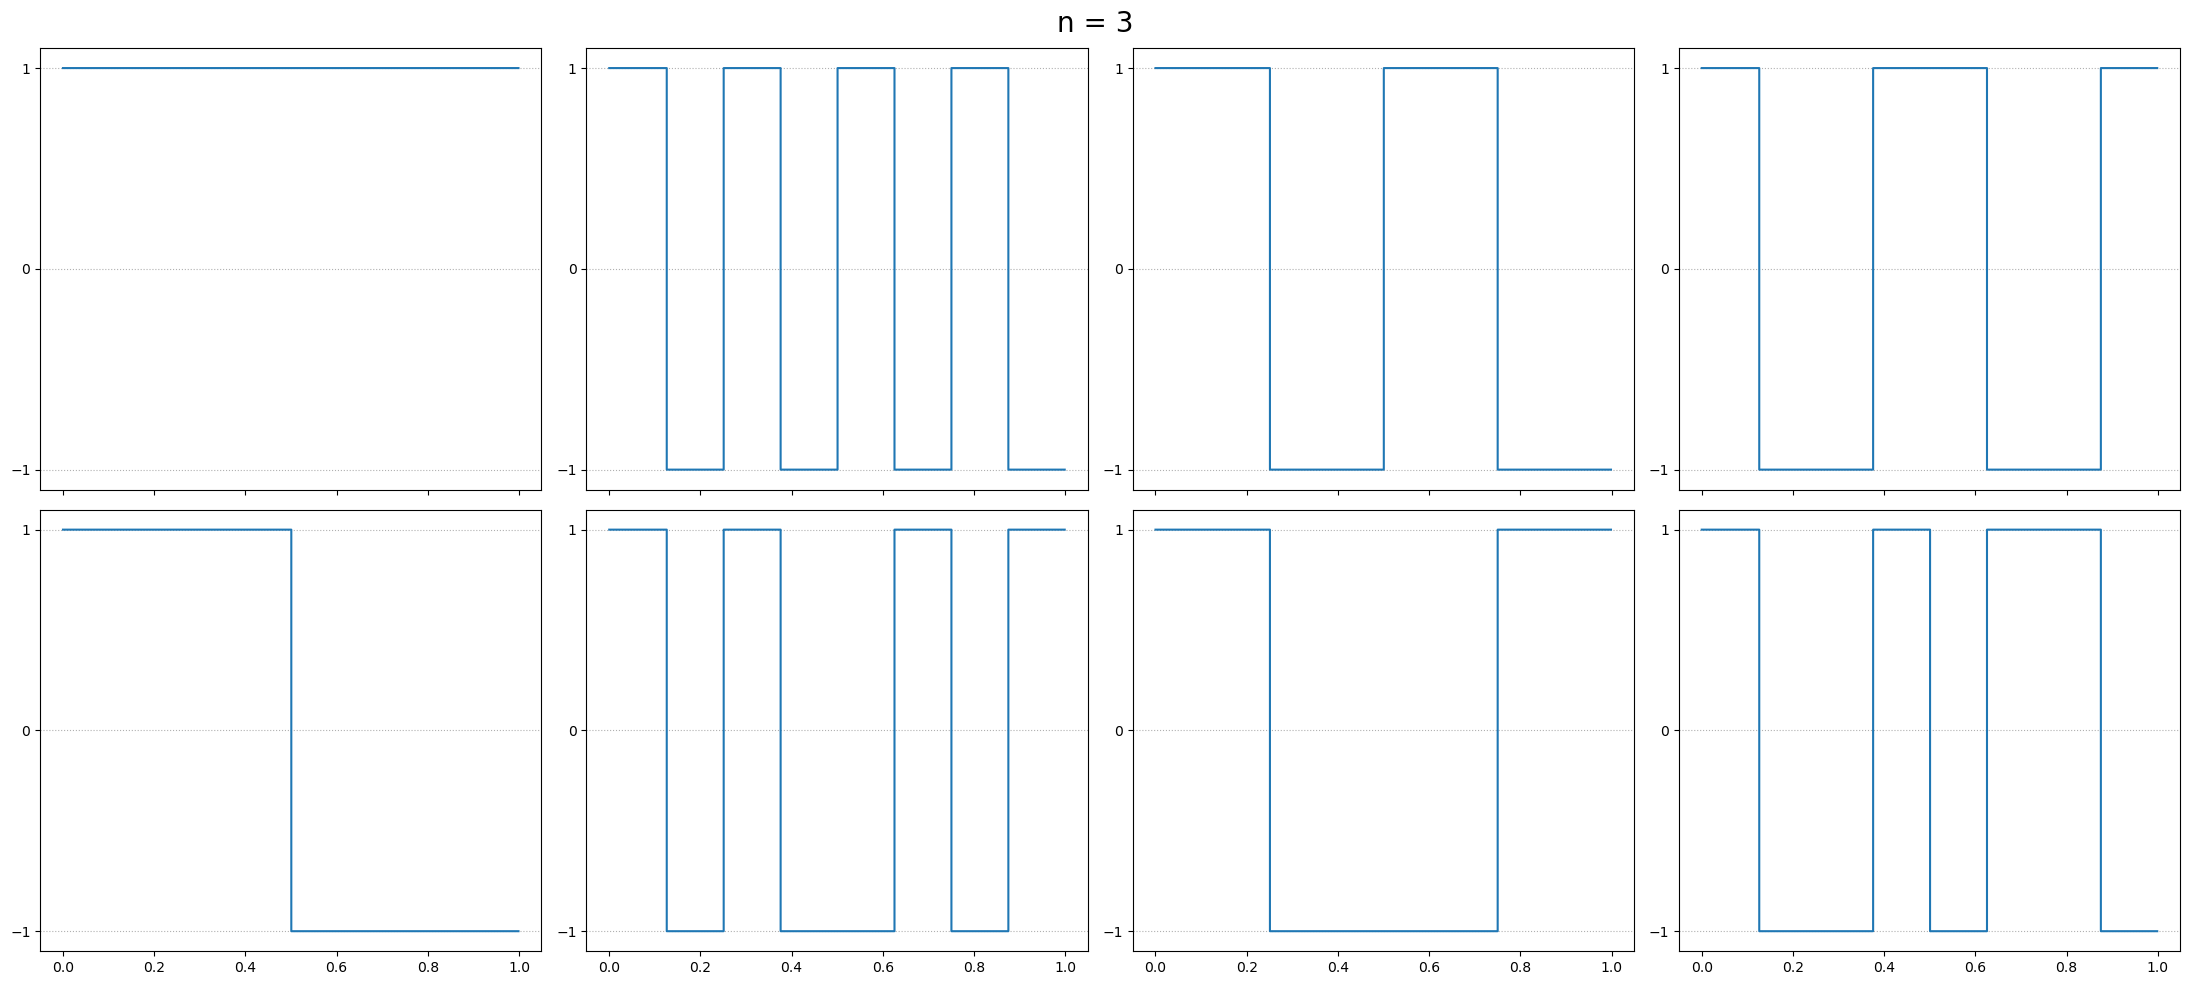

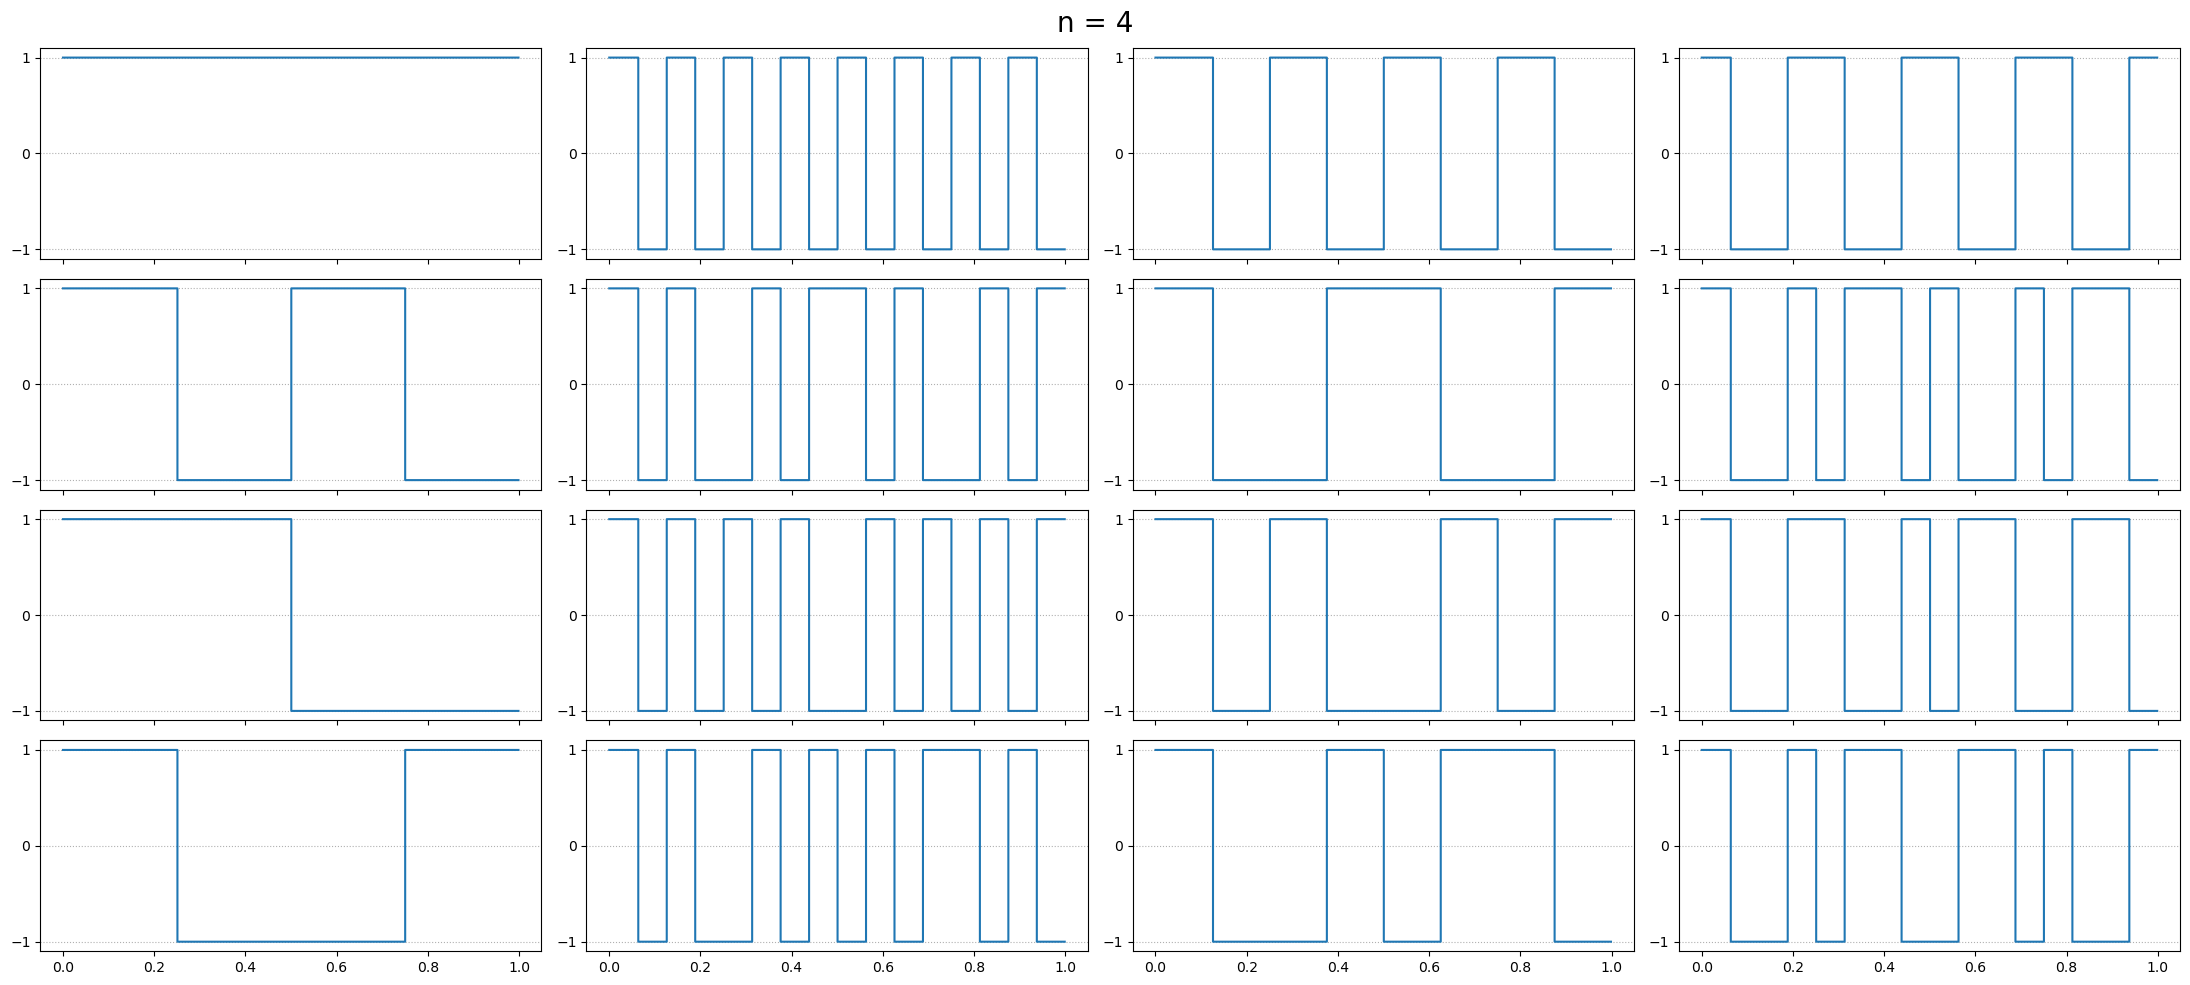

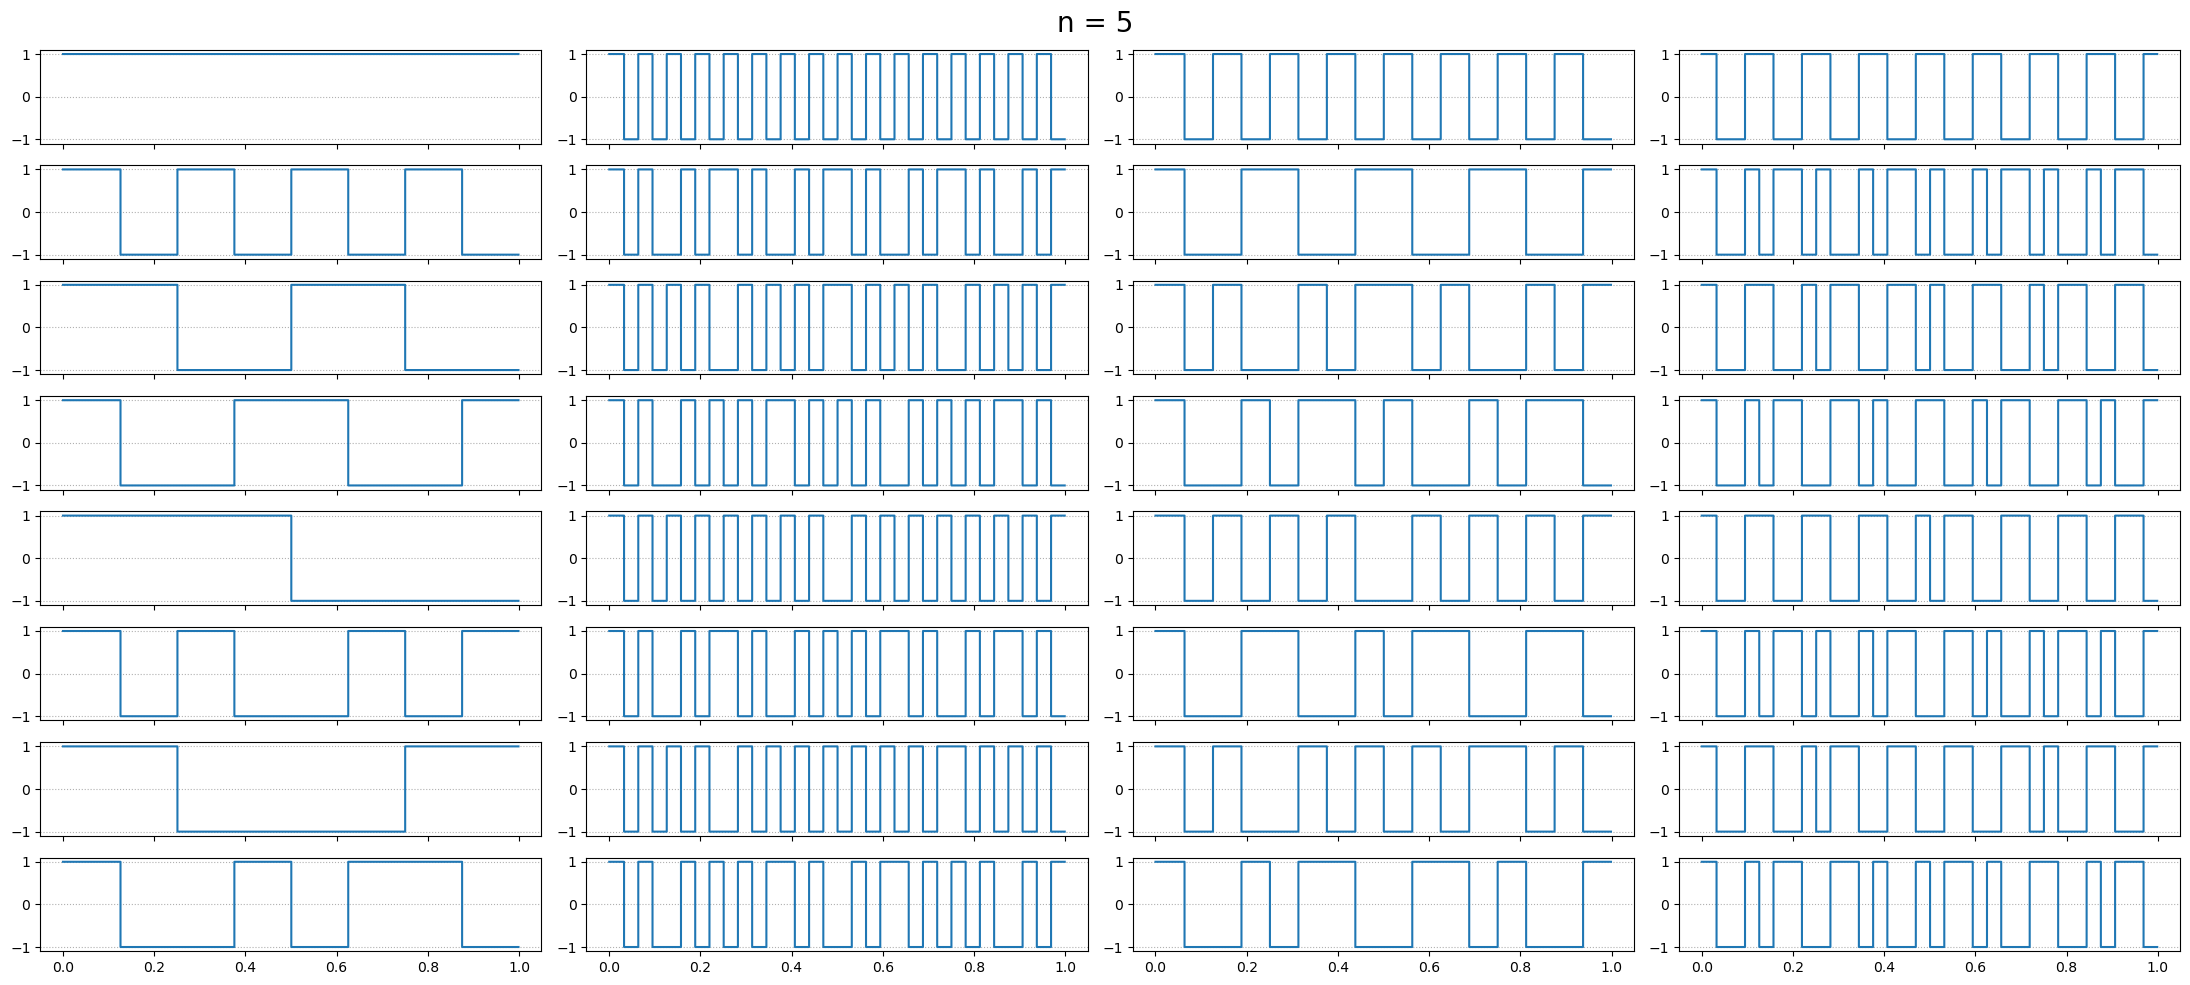

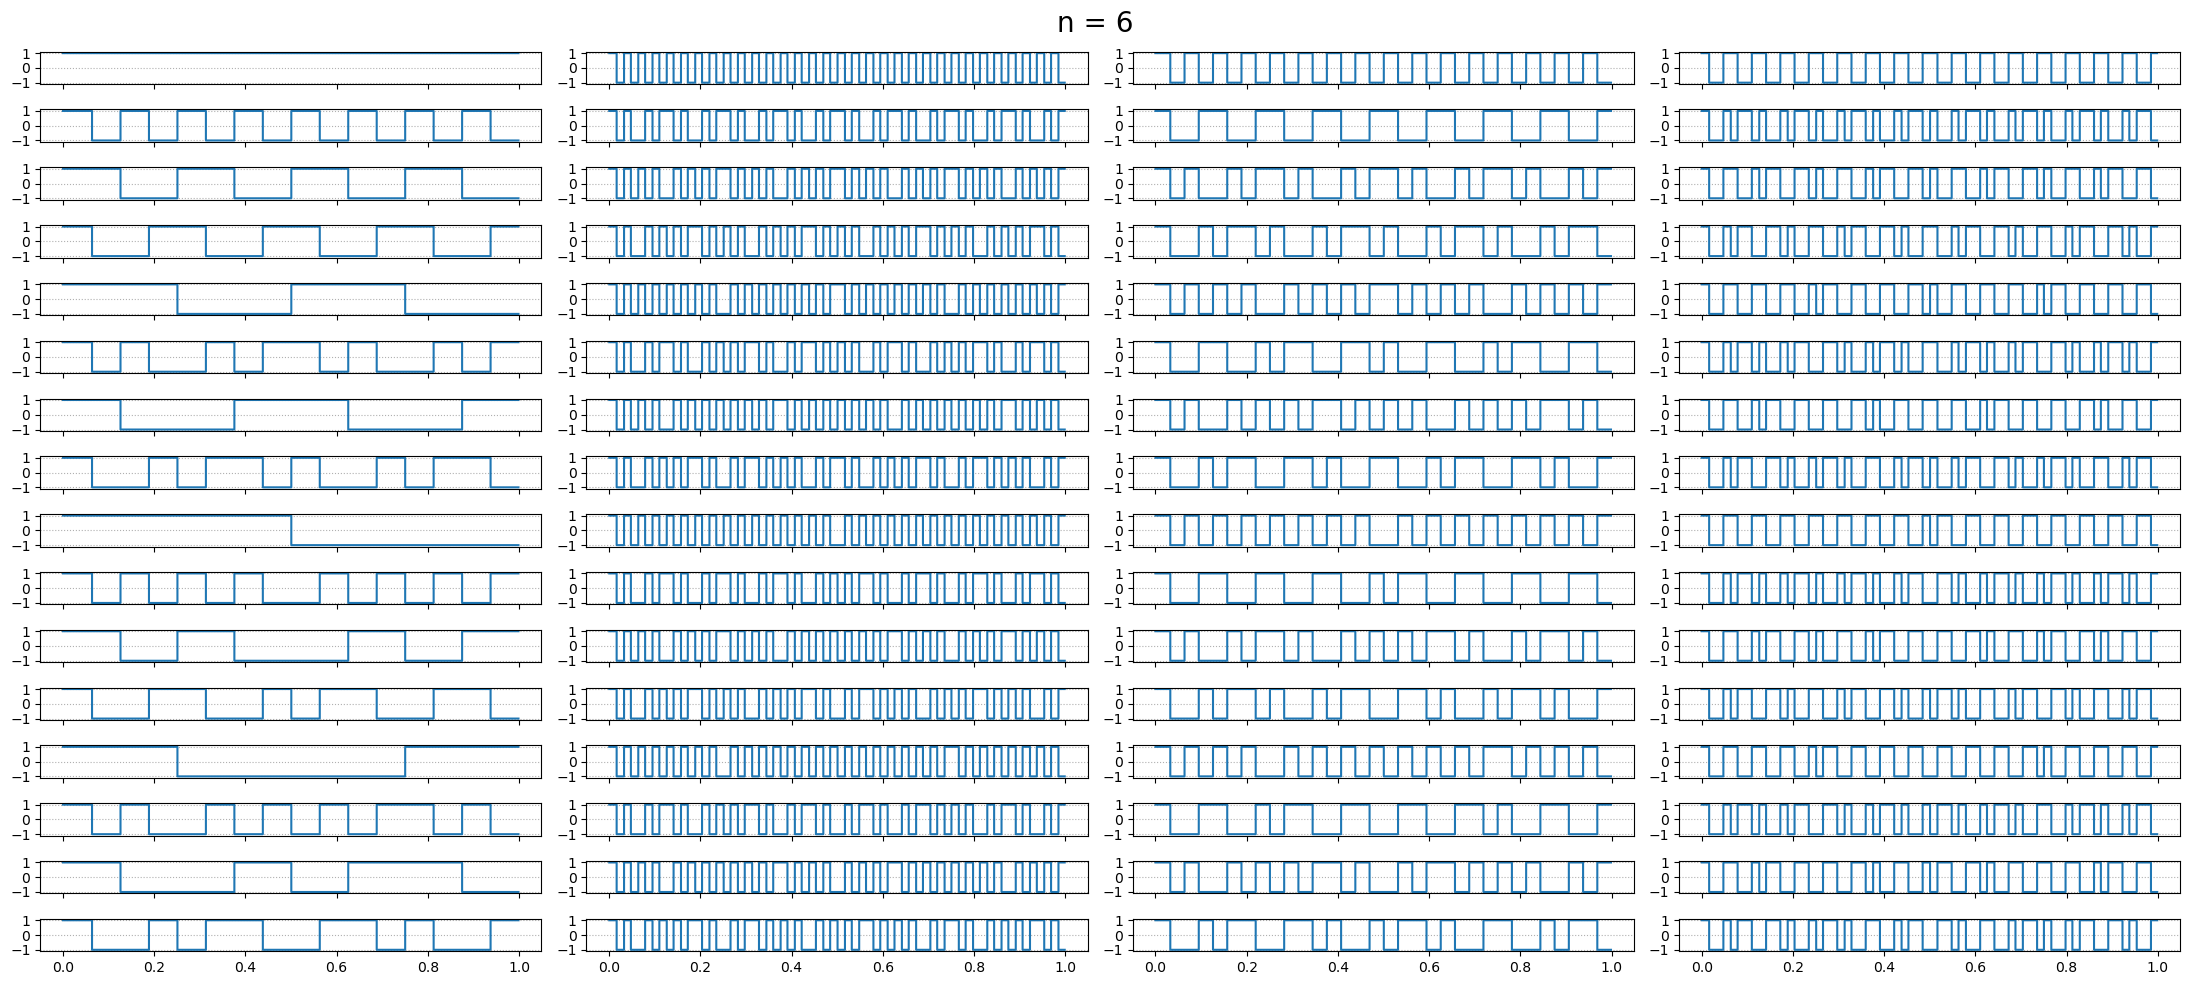

In [209]:
show_family(h_family)

### Section C

In [201]:
# walsh hadamard stems from hadamard matrix
def walsh_hadamard(n: int) -> np.ndarray:
    H = hadamard(n)
    # sign-changes per row 
    jumps = (np.abs(np.diff(H, axis=1)) > 0).sum(axis=1)
    idx   = np.argsort(jumps, kind='stable')
    return H[idx]

## Section D

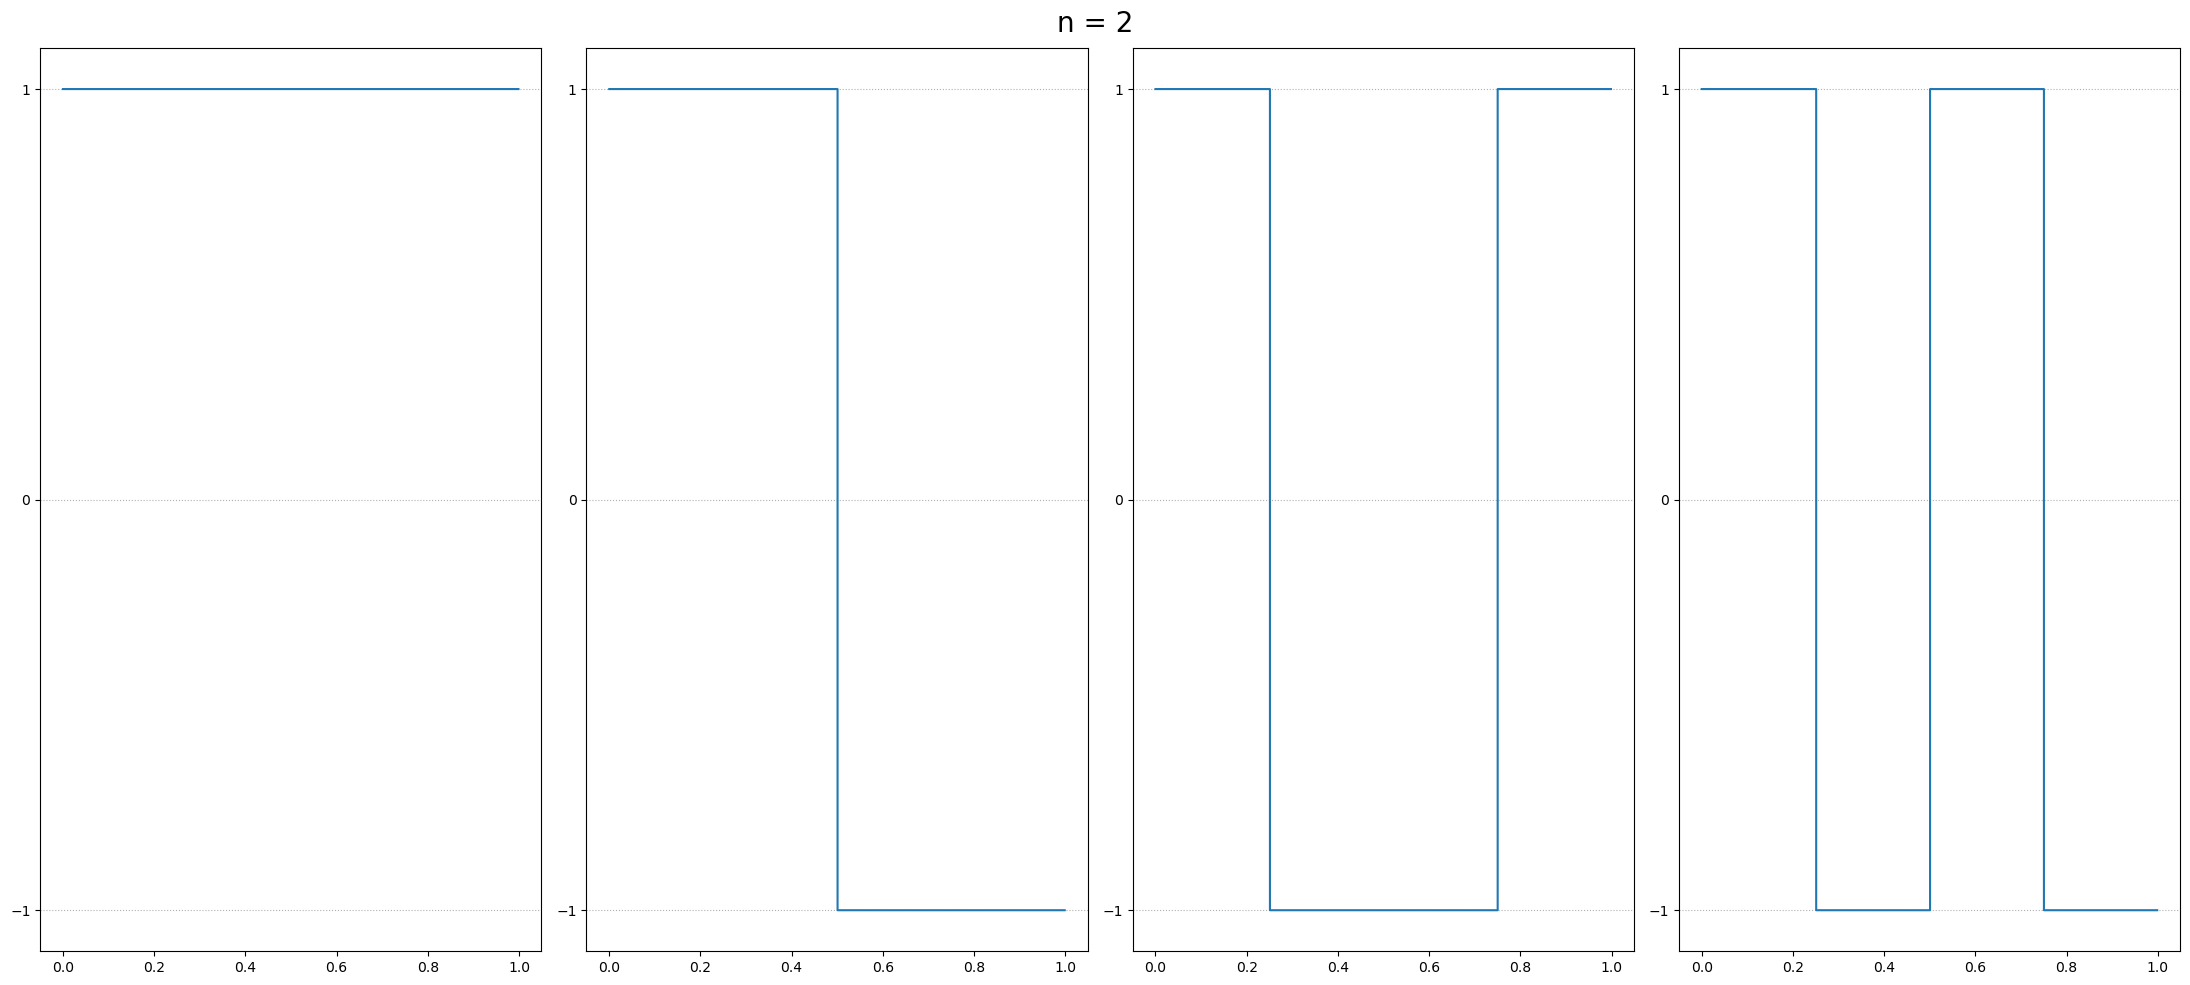

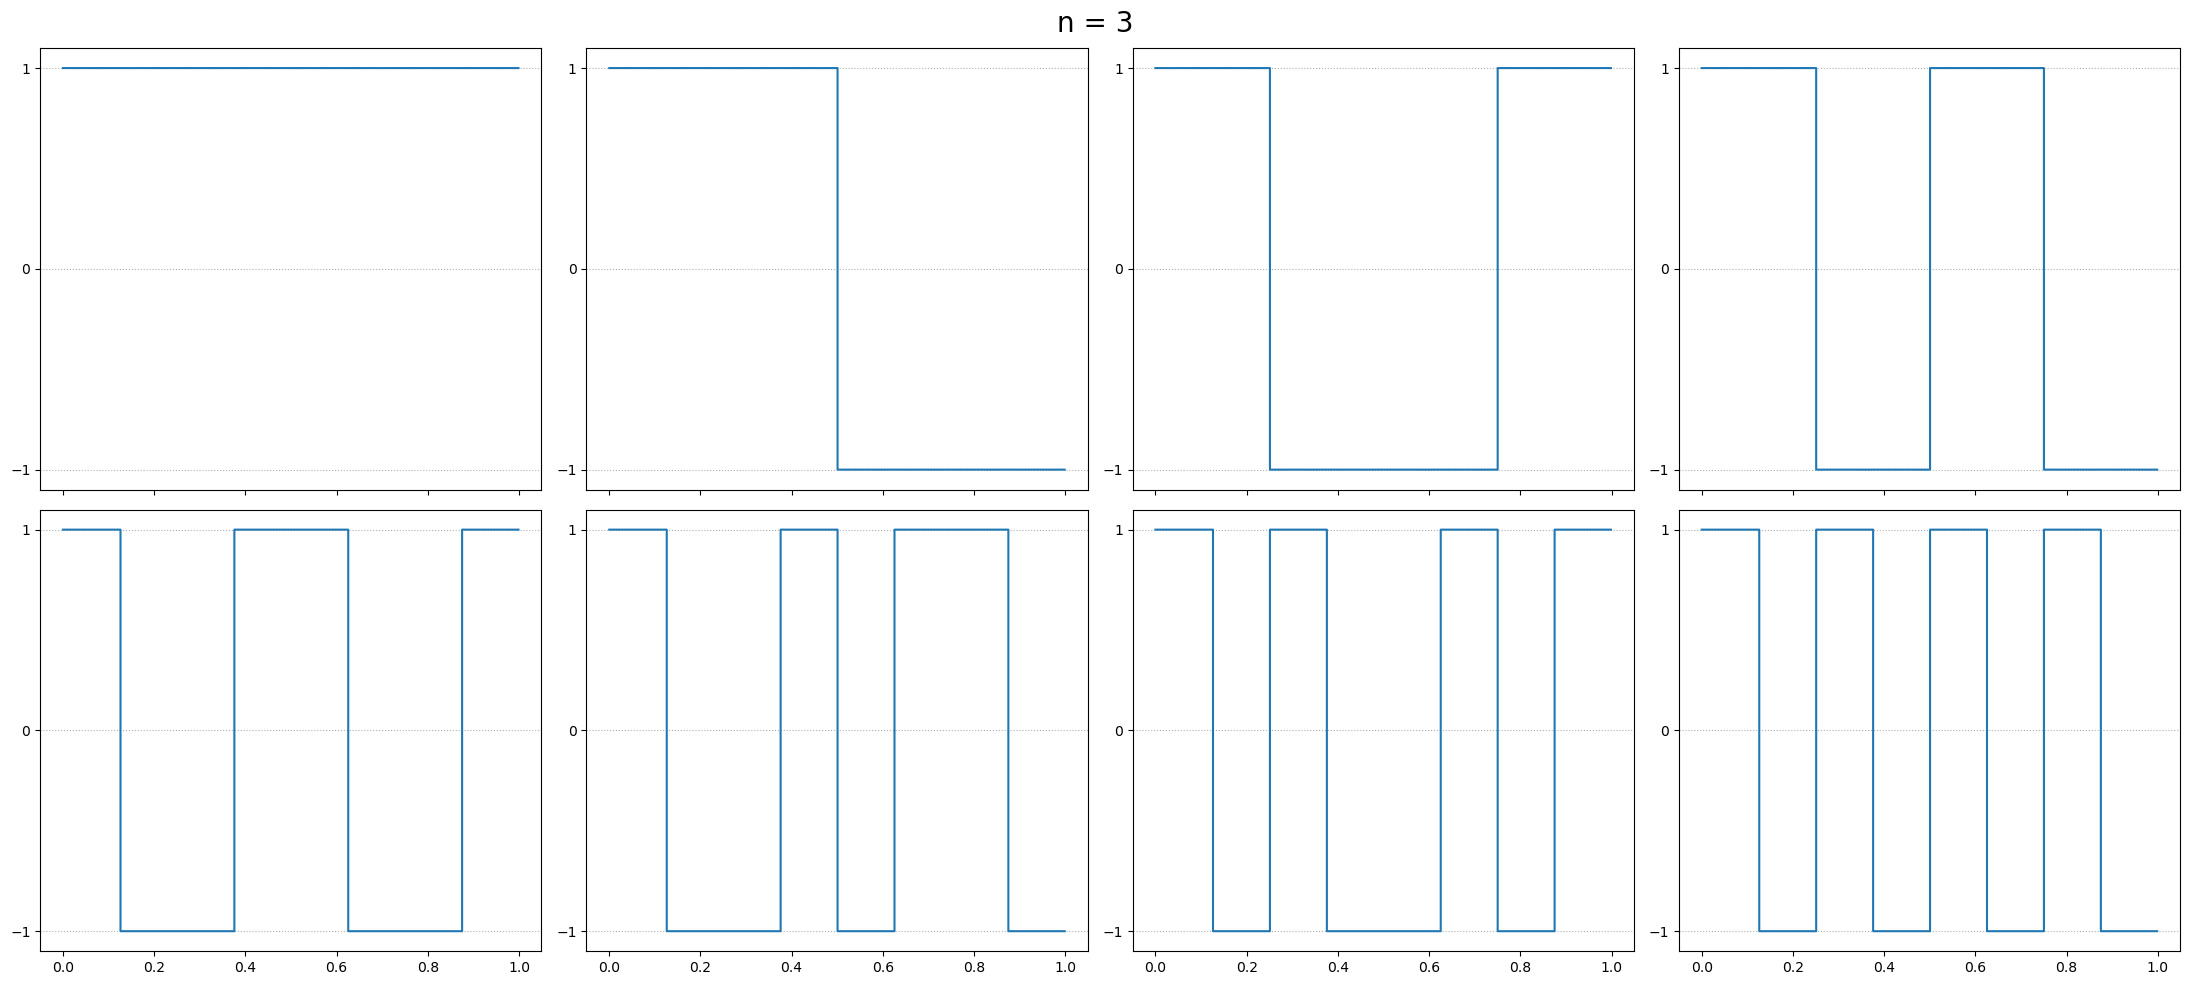

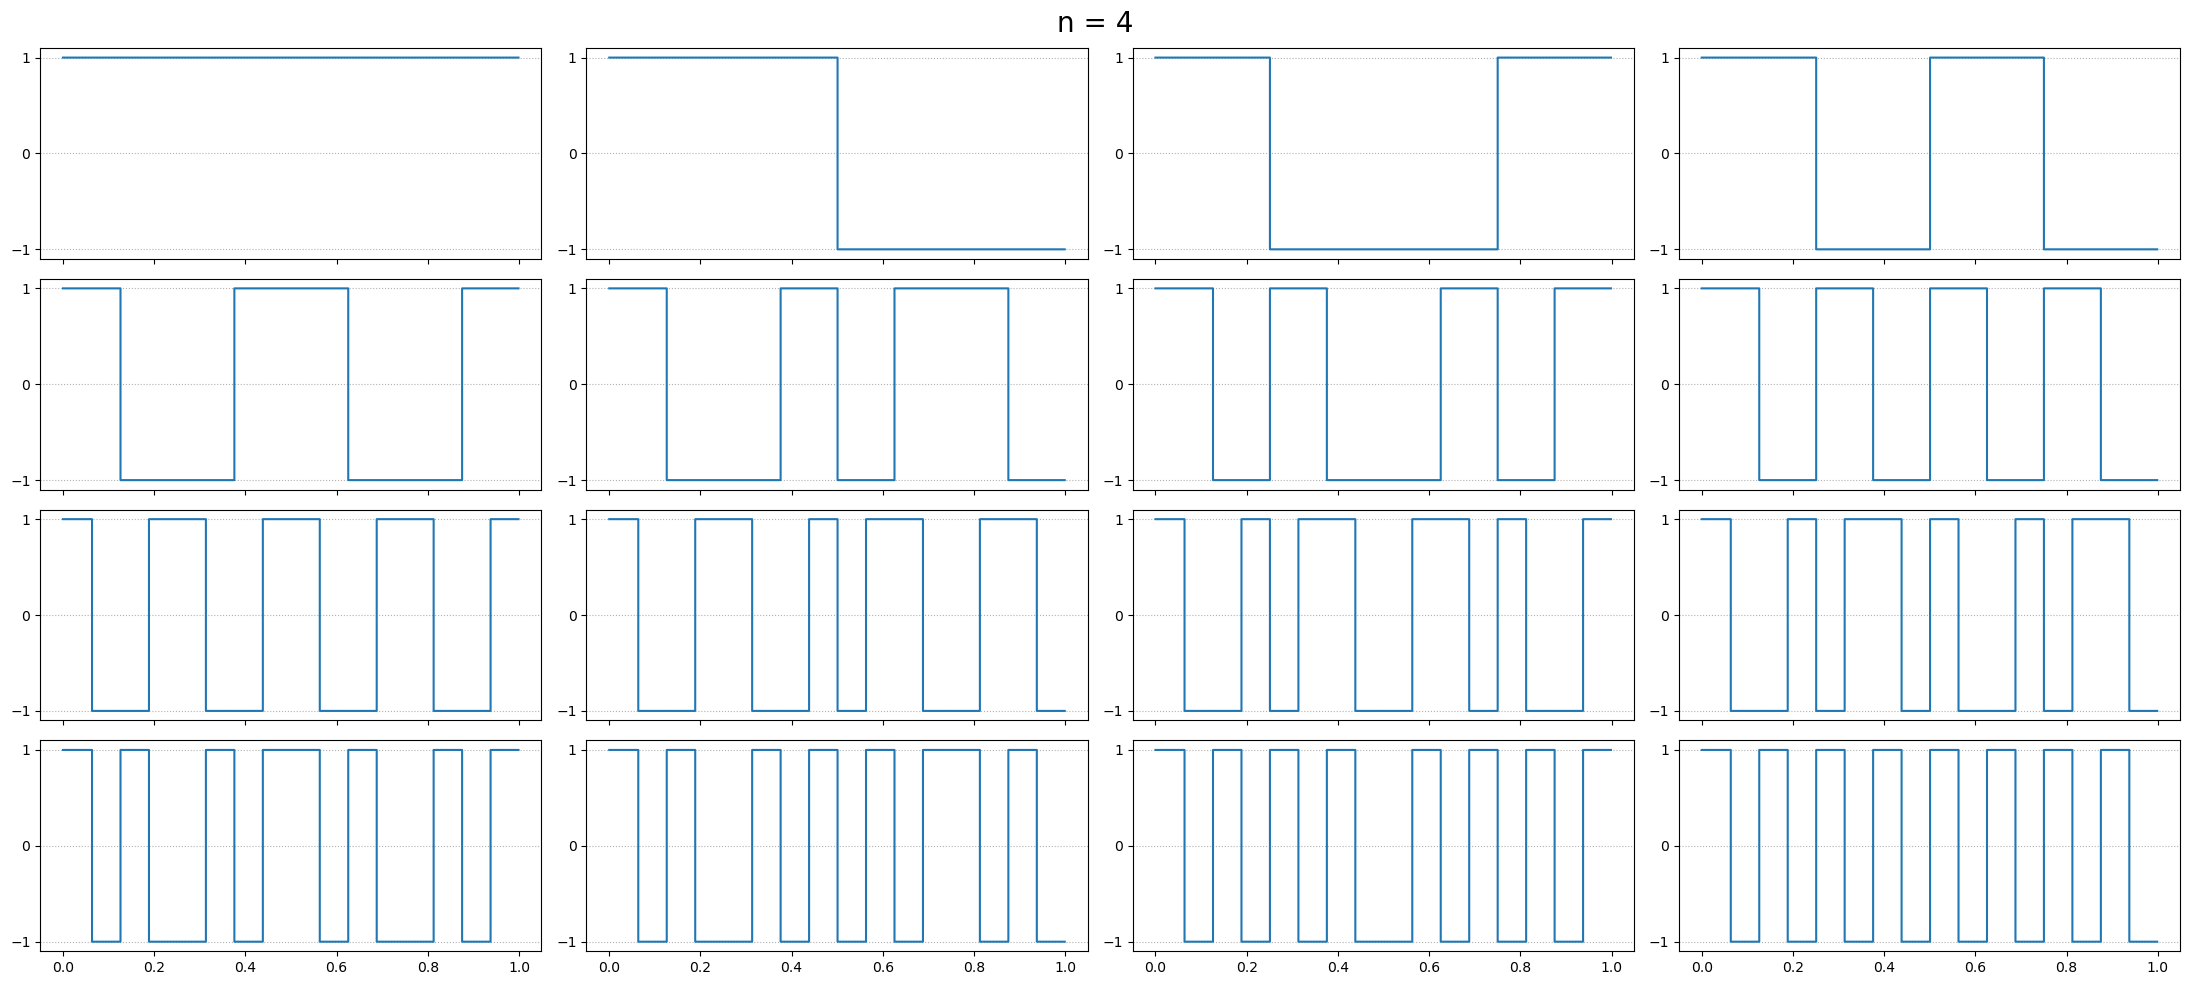

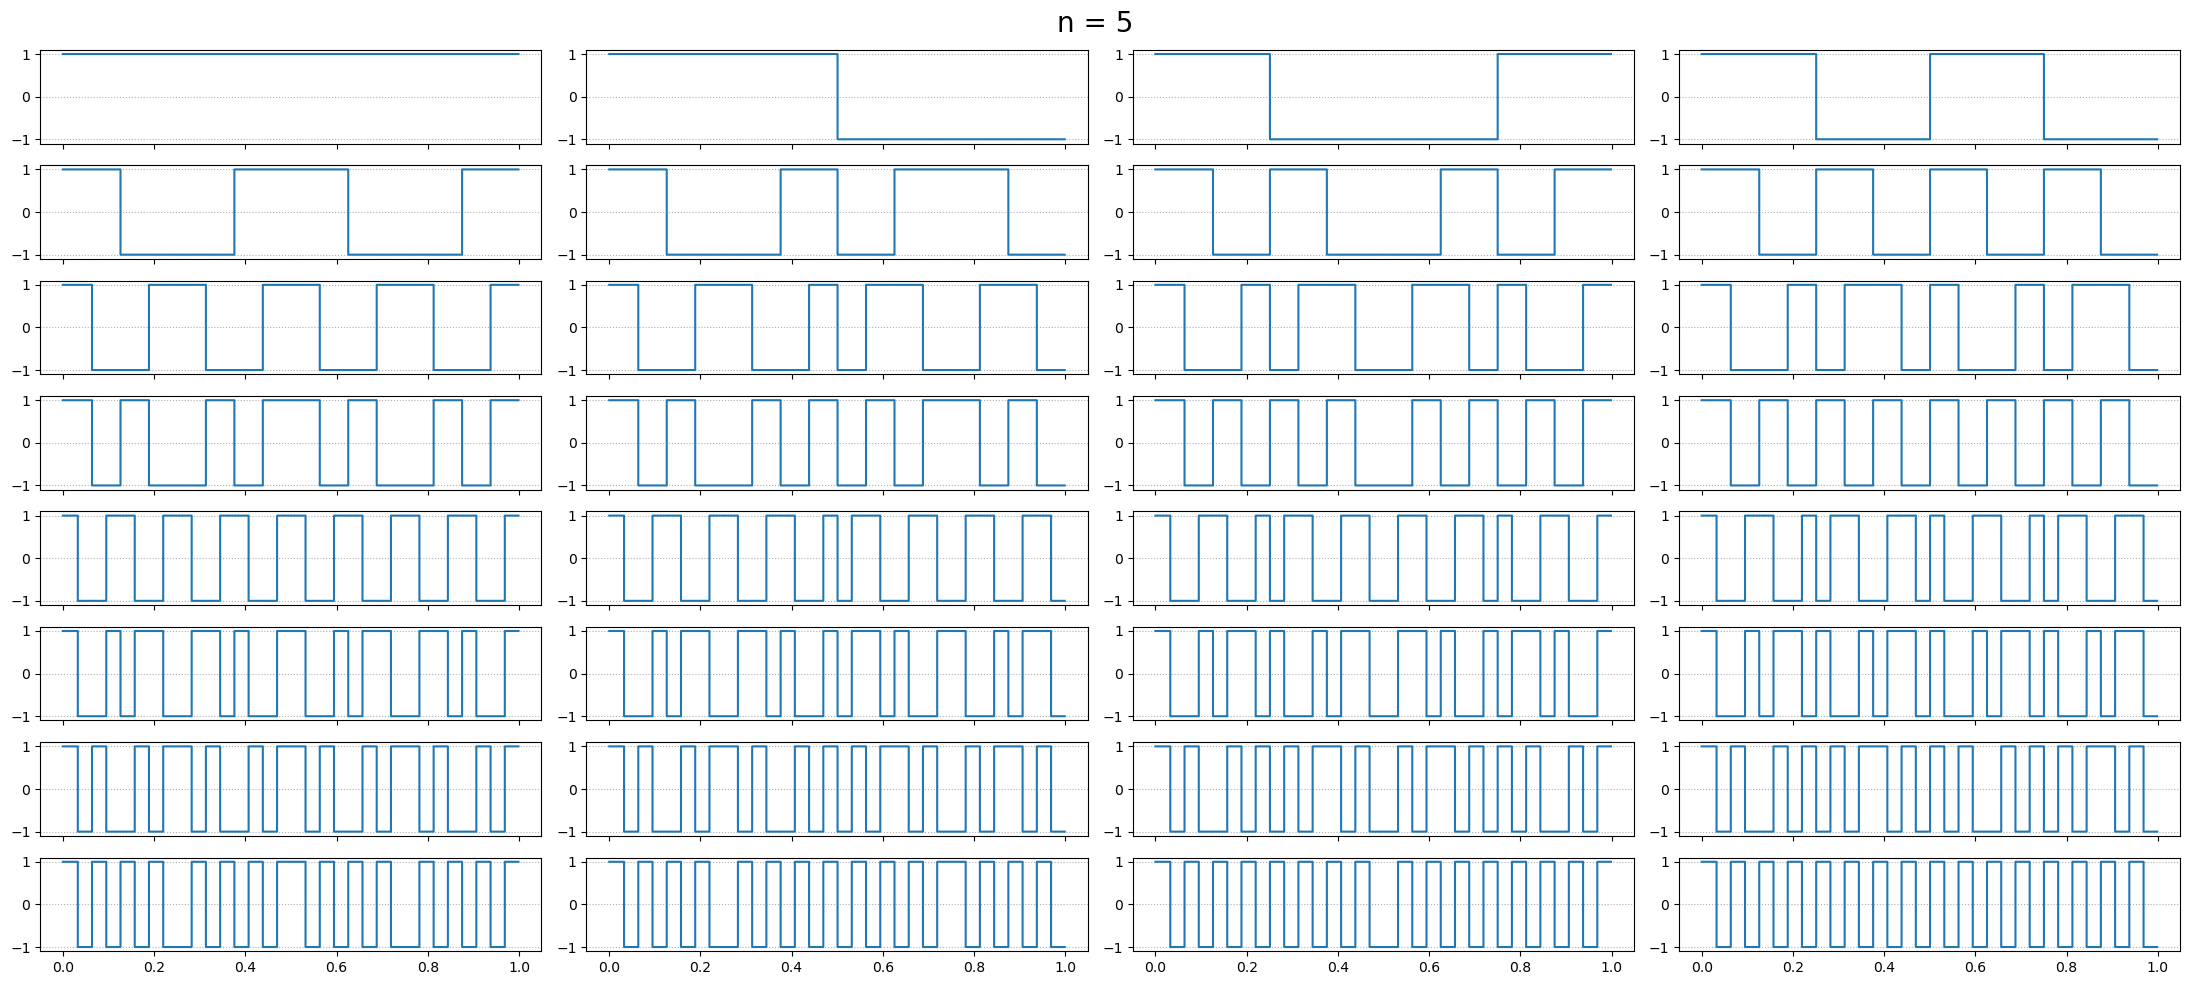

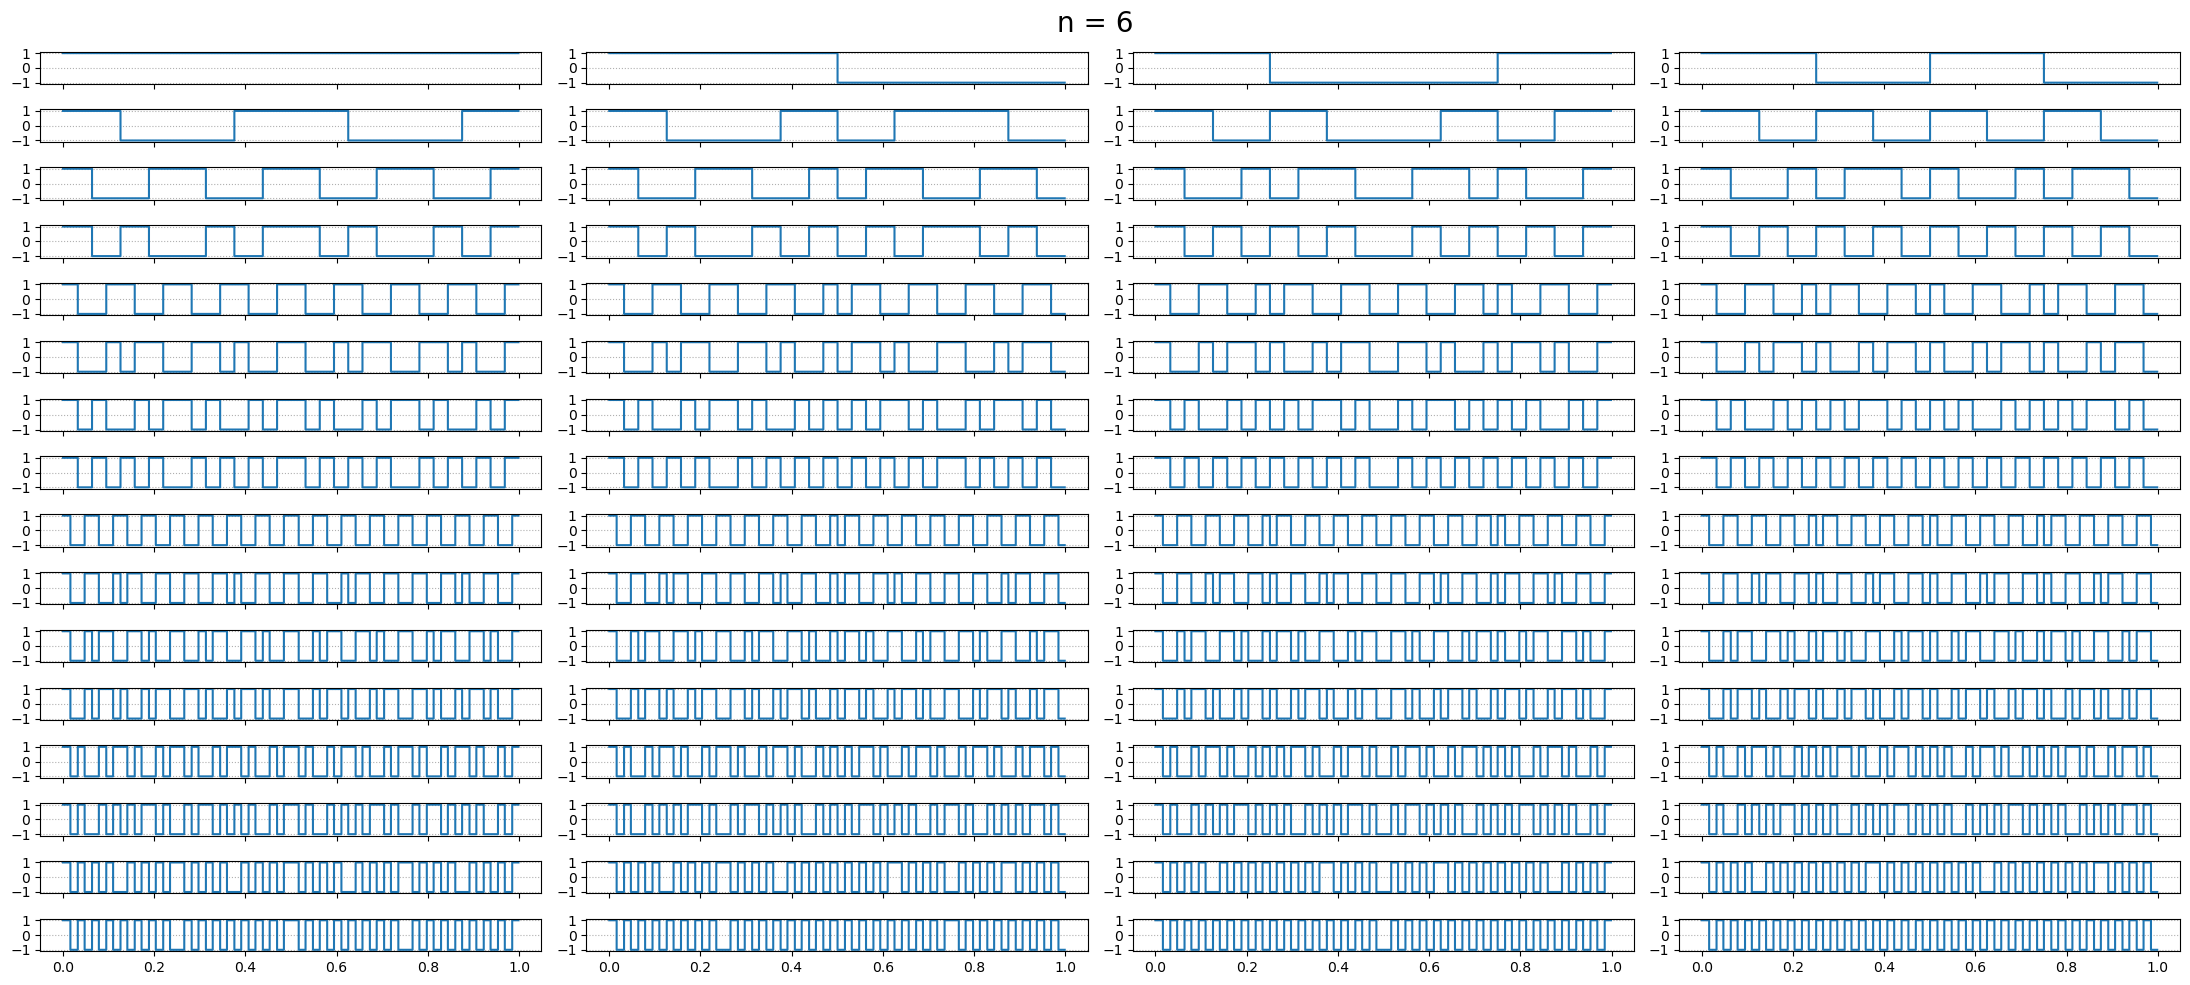

In [210]:
# build hw_i(t) 
def hw_family(n: int, x: np.ndarray):
    k  = 2**n
    H  = walsh_hadamard(n)  
    B  = np.vstack([standard_basis_func(j, x, n) for j in range(k)])  # all basis functions
    return np.sqrt(k) * (H.T @ B)     # row i = hw_i(t)

x = np.linspace(0, 1, 801, endpoint=False)  

show_family(hw_family)

### Section E

In [213]:
# recursive definition of the haar matrix
def haar(n: int) -> np.ndarray:
    """
    Orthonormal Haar matrix H_{2^n}  (rows have unit 2-norm).
    """
    if n == 1:
        return np.array([[1.,  1.],
                         [1., -1.]]) / np.sqrt(2)

    H_N = haar(n - 1)                         # size 2^{n-1}
    N    = H_N.shape[0]

    top    = np.kron(H_N, np.array([[1.,  1.]]))
    bottom = np.kron(np.eye(N), np.array([[1., -1.]]))

    return np.vstack((top, bottom)) / np.sqrt(2)

### Section D

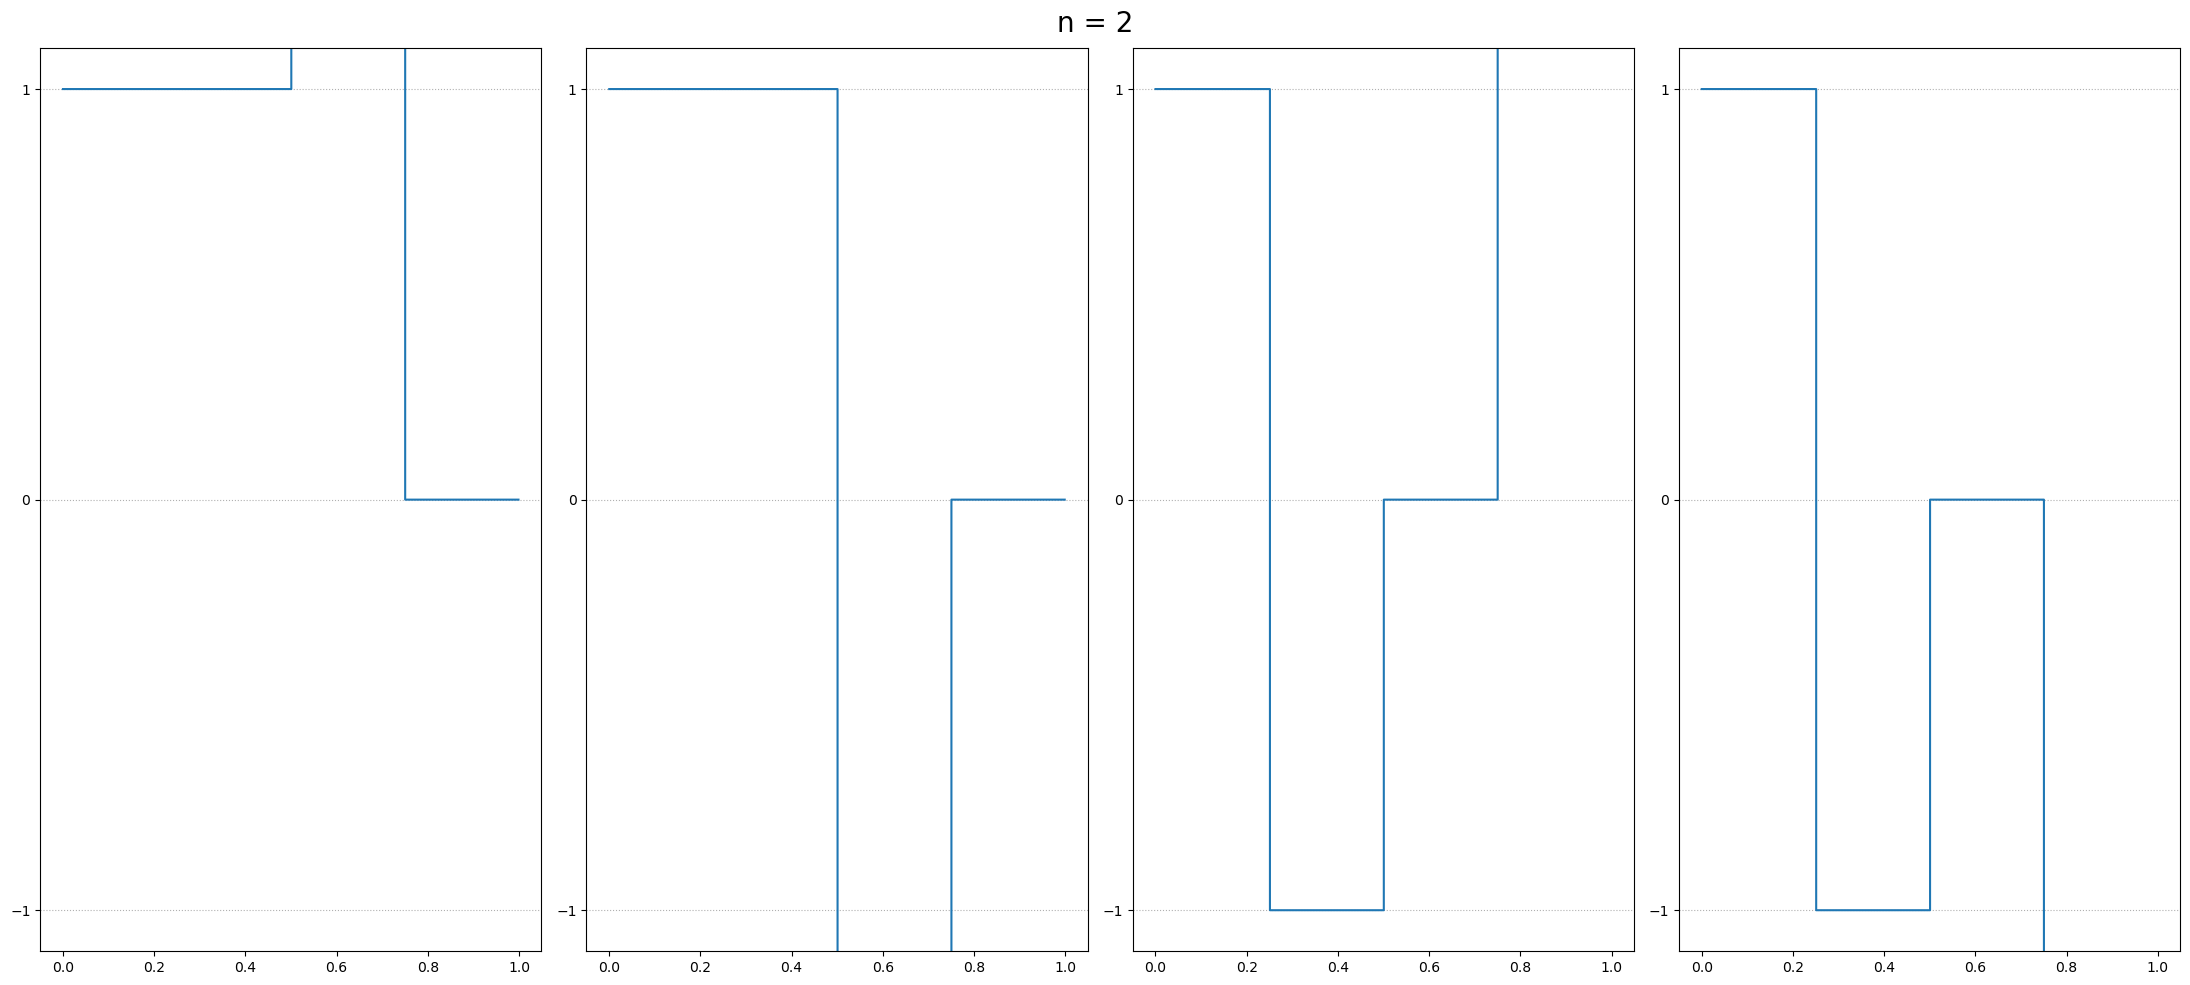

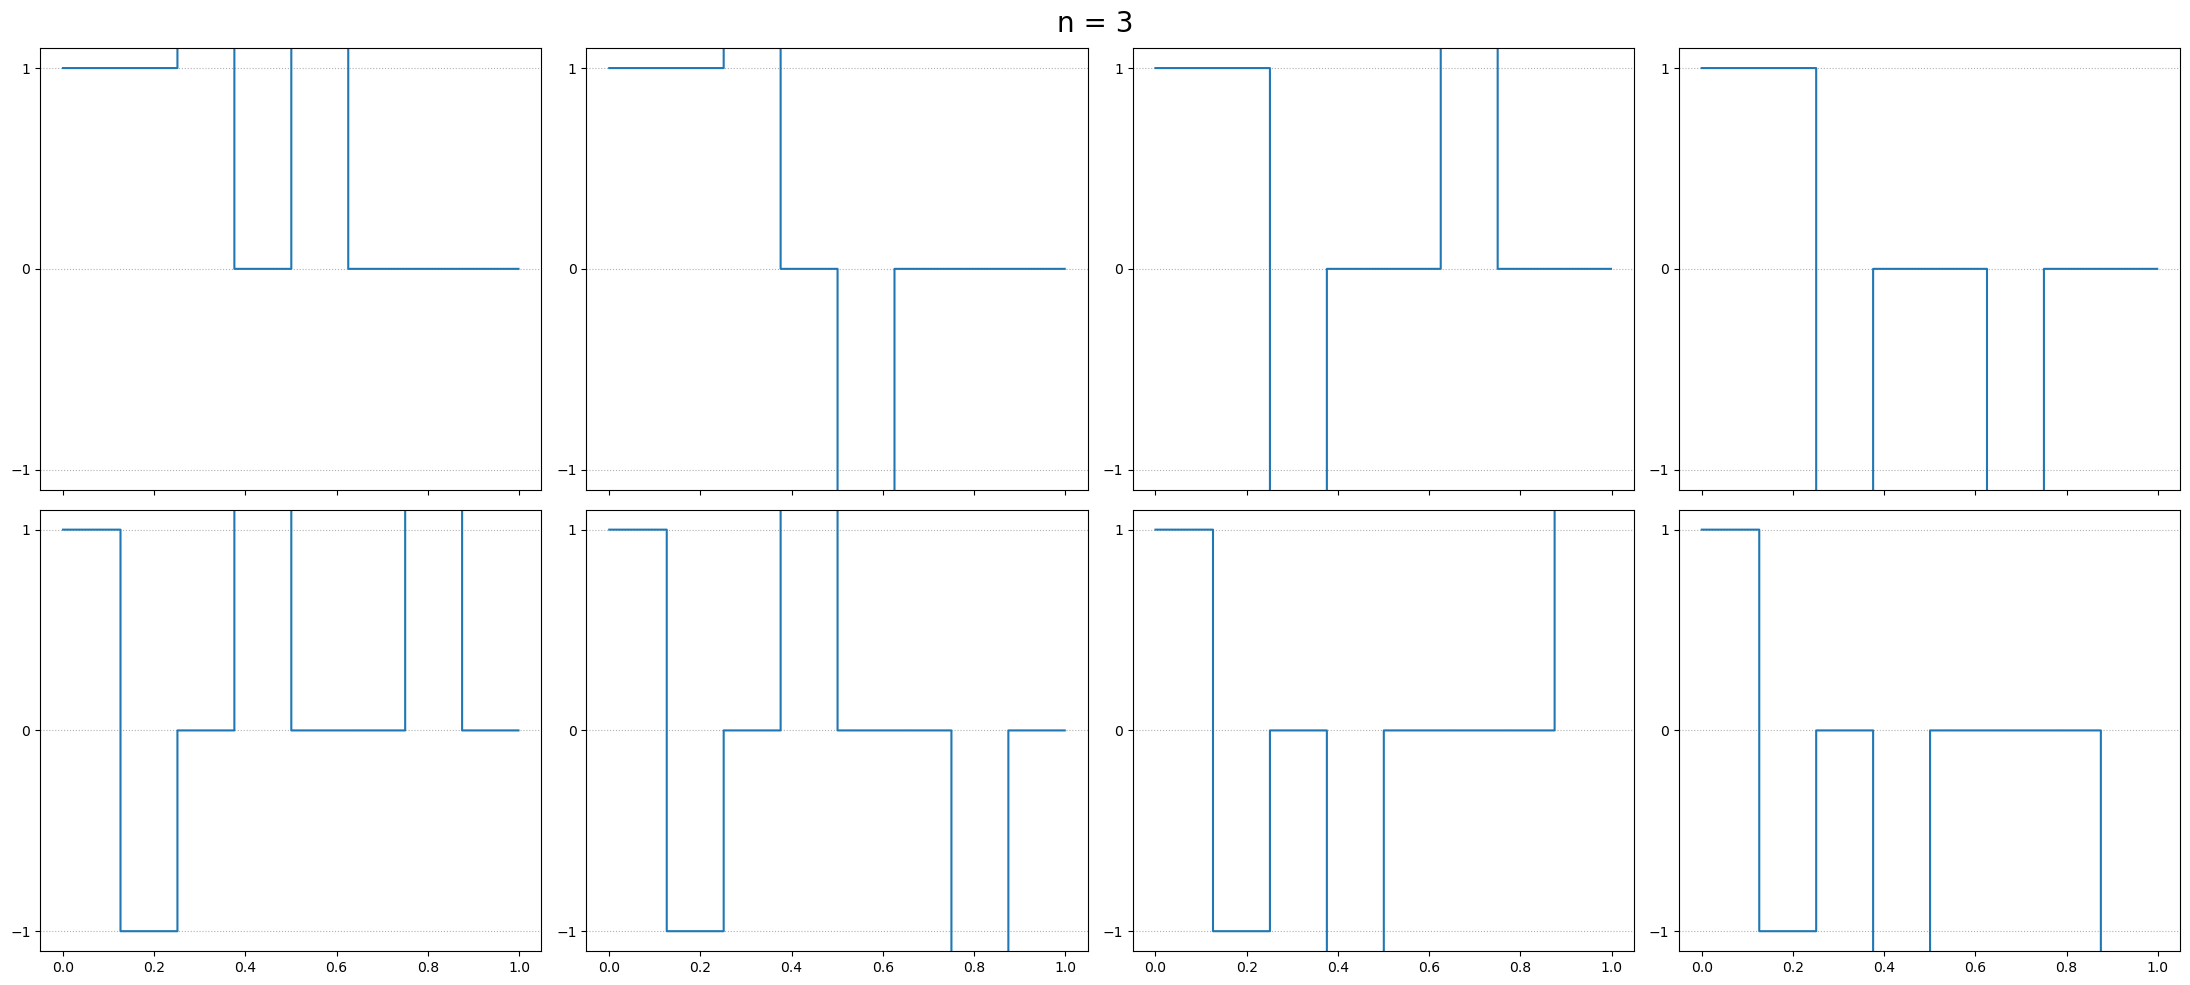

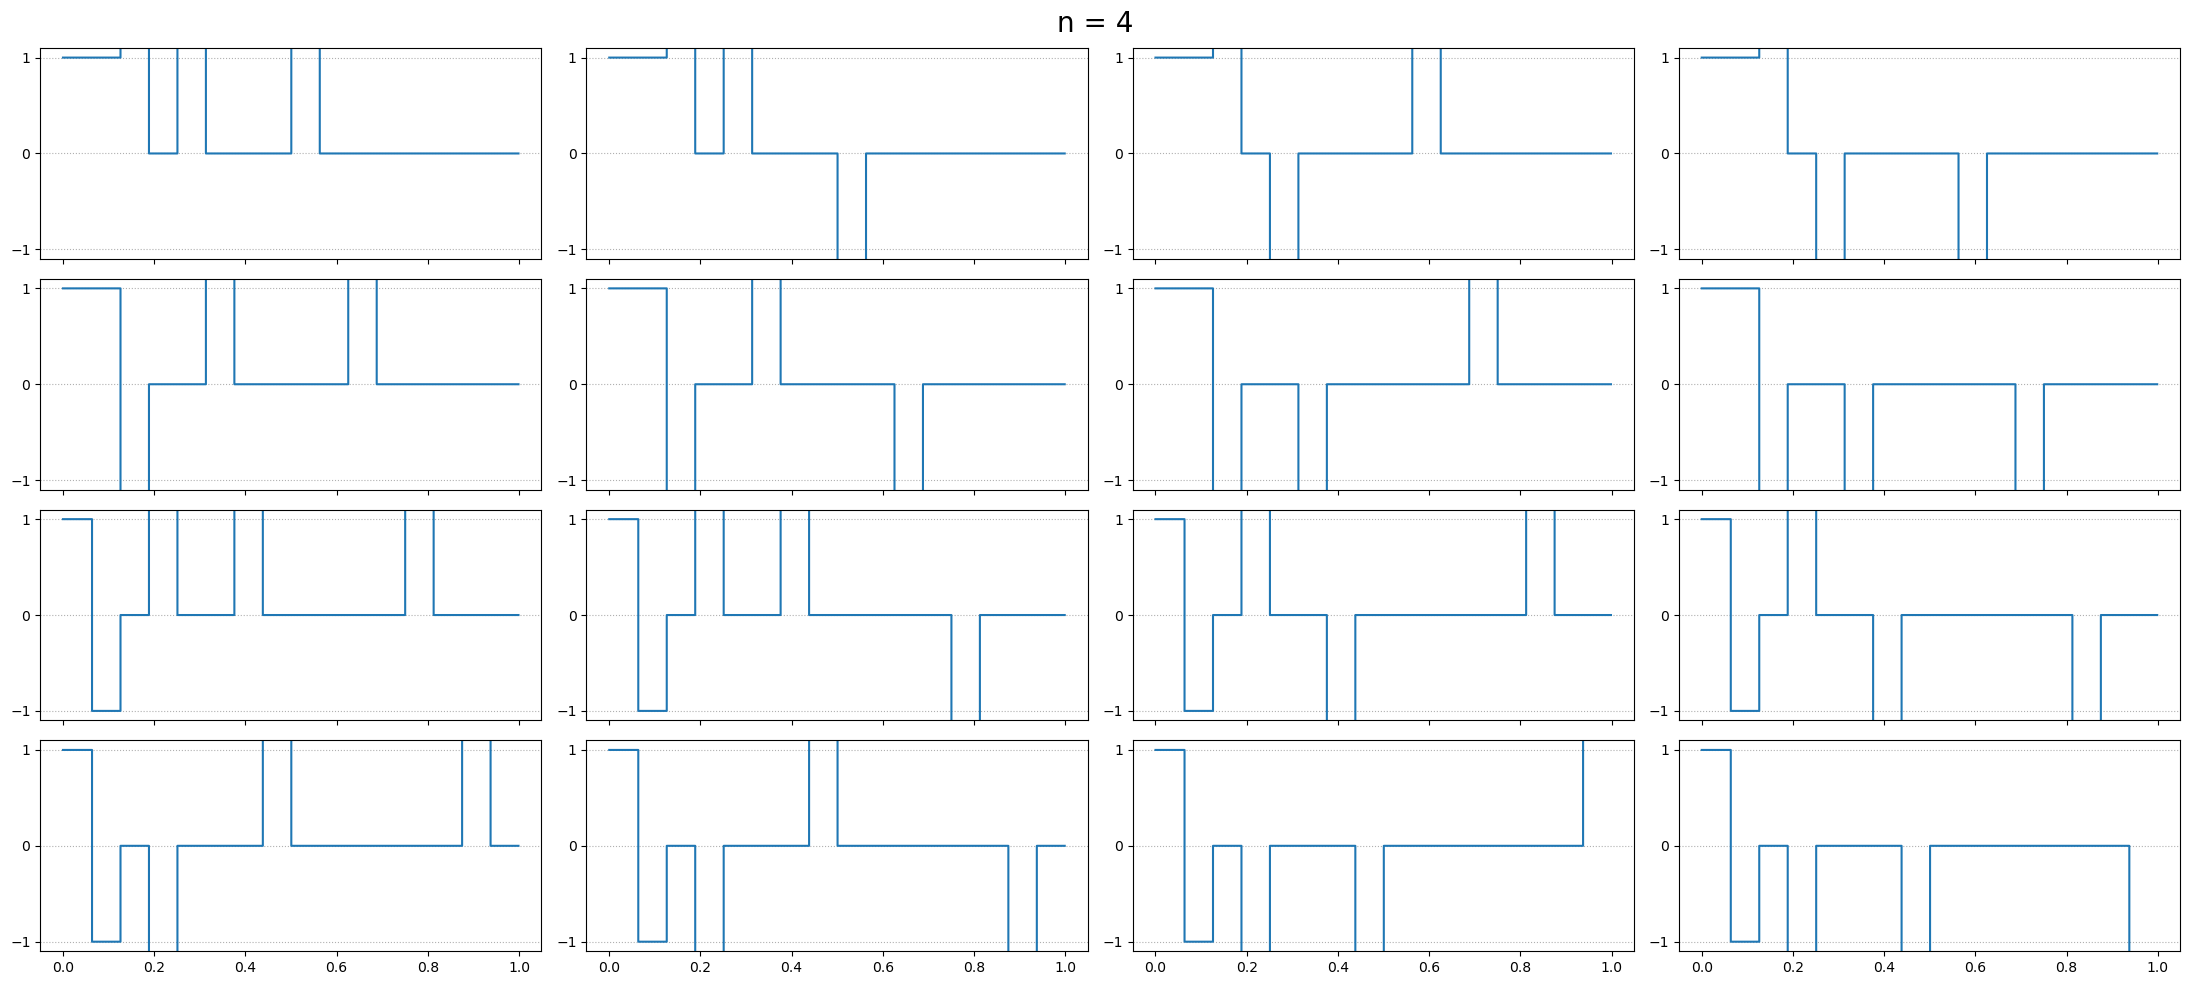

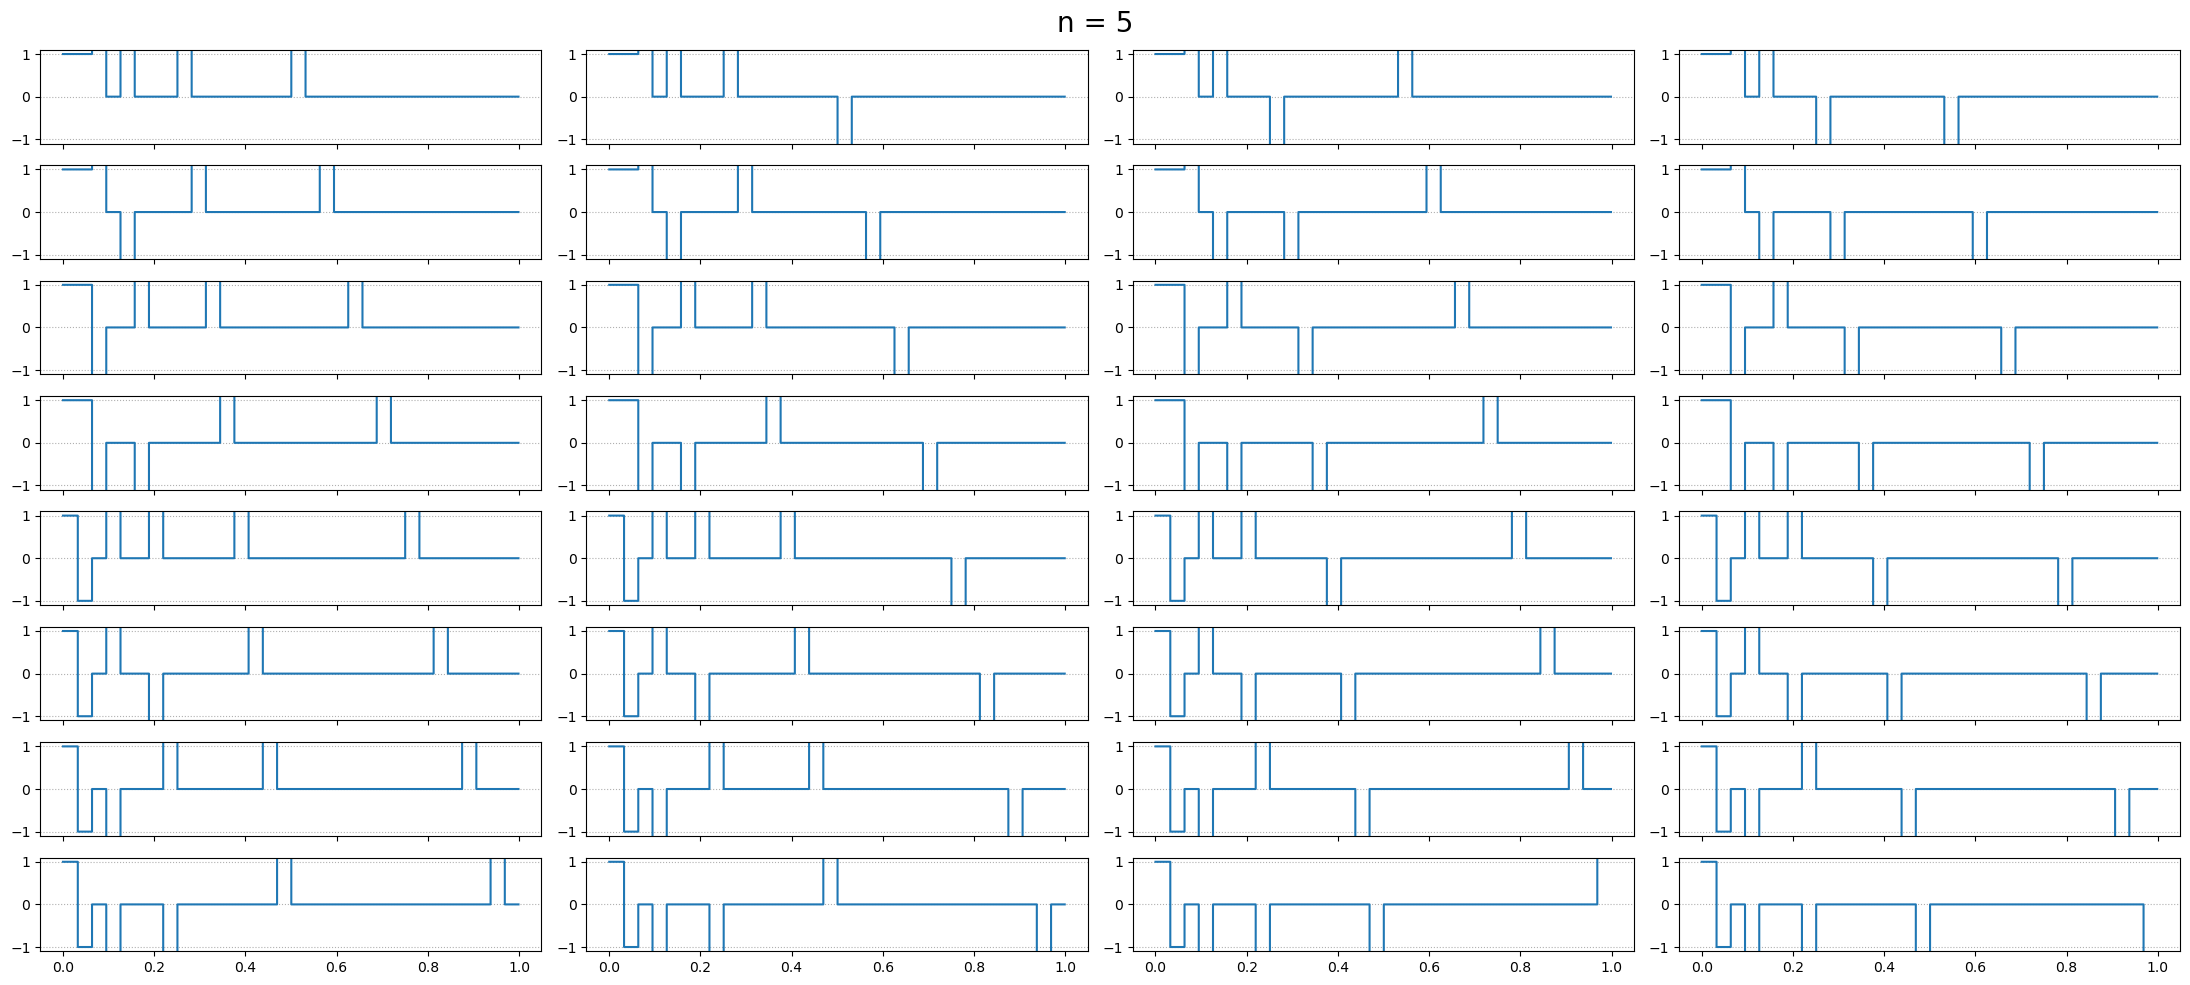

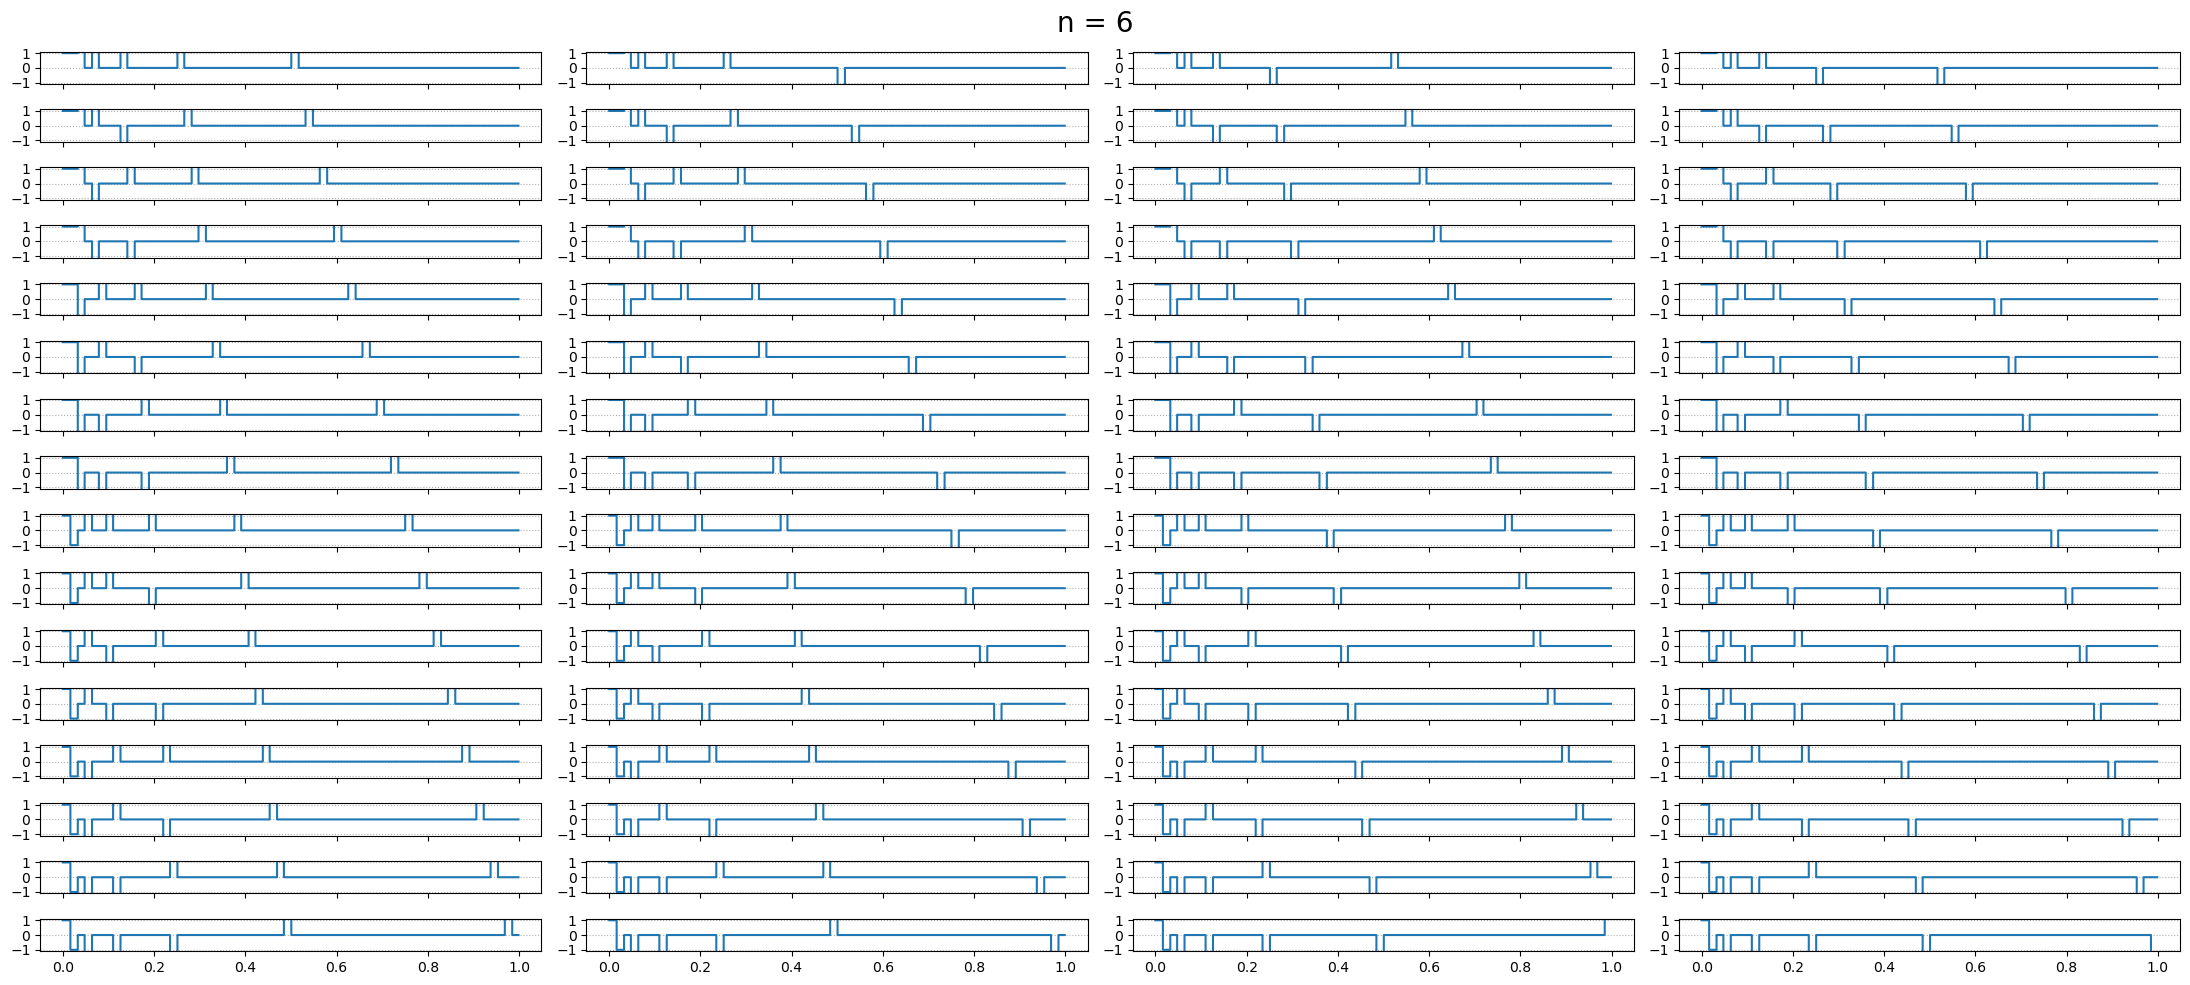

In [216]:
# build hw_i(t) 
def ha_family(n: int, x: np.ndarray):
    k  = 2**n
    H  = haar(n)  
    B  = np.vstack([standard_basis_func(j, x, n) for j in range(k)])  # all basis functions
    return np.sqrt(k) * (H.T @ B)     # row i = hw_i(t)

x = np.linspace(0, 1, 801, endpoint=False)  

show_family(ha_family)